# Set up

In [1]:
import pickle
import json
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#import stan
import pandas as pd
from scipy import stats
from scipy.special import softmax
from datetime import datetime
import time
import math
from scipy.stats import multinomial
from scipy.stats import dirichlet
import matplotlib as matplotlib
import ternary
import mpltern

# Functions

## Functions for distribution analysis

- get_plot(): produces a distribution plot with samples from the posterior
- get_samples(): obtains samples from the posterior
- get_priors(): get the priors of a corresponding run, it also can plot them by calling get_plot()
- densities(): computes the density of a posterior on its true.  (Strictly speaking it is a sampling using the posterior samples.)

In [2]:
def cumulative(a,b):
    if len(a) != len(b): 
        print('Lengths do not match')
        return
    out = []
    for i in range(len(a)):
        out.append(np.dot(a[:i+1],b[:i+1]))
    return out

In [3]:
def get_plot(key, sorted_posterior, pjs, pbs, save='' ):
    if key[-2:] == 'hs':
        mymodel = 'Gaussian Process'
    elif key[-2:] == 'Dr':
        mymodel = 'Dirichlet'
    elif key[-2:] == 'UM' or key[-2:] == 'um' :
        mymodel = 'Unimodal'
    elif key[-2:] == 'PE':
        mymodel = 'Point Estimate'
    if key[:2] == '1D':
        mymodel = mymodel + ' (1D)'

    plt.figure(dpi=140)
    for k in range(400):
        posterior0=[]
        l = np.random.randint(len(sorted_posterior))  # use this to use random from posterior
        #l = k  # use this line to get the most likely samples from the posterior (MAP and surroundings)
        for i in range(len(pjs)):
            name = pjs[i]
            posterior0.append(sorted_posterior.iloc[l][name])
        if key[-2:] == 'hs':
            posterior0 = softmax(posterior0)
        if k==0:
            line1, = plt.plot(midbins,posterior0, '-r', linewidth=0.1, alpha=0.2 )    
        else:
            plt.plot(midbins,posterior0, '-r', linewidth=0.1, alpha=0.2 )    
        posterior1=[]
        for i in range(len(pbs)):
            name = pbs[i]
            posterior1.append(sorted_posterior.iloc[l][name])
        if key[-2:] == 'hs':
            posterior1 = softmax(posterior1)
        if k == 0:
            line2, = plt.plot(midbins,posterior1, '-b', linewidth=0.1, alpha=0.2 )
        else:
            plt.plot(midbins,posterior1, '-b', linewidth=0.1, alpha=0.2 )
    
    if key[-2:] == 'hs' or key[-2:] == 'Dr':
        line5, = plt.plot(prior_distribution[0][0], prior_distribution[0][1], ':', color = 'red', label='Prior mean '+classname[0]+'-distribution')            
        line6, = plt.plot(prior_distribution[1][0], prior_distribution[1][1], ':', color = 'blue', label='Prior mean '+classname[1]+'-distribution')            

    line3, = plt.plot(true_distribution[0][0], true_distribution[0][1], '-.', color = 'red', label='True '+classname[0]+'-distribution')
    line4, = plt.plot(true_distribution[1][0], true_distribution[1][1], '-.', color = 'blue', label='True '+classname[1]+'-distribution')

    plt.scatter(midbins, [x[1] for x in sampledclass0], color='red', s=15, label='Actual data for '+classname[0])
    plt.scatter(midbins, [x[1] for x in sampledclass1], color='blue', s=15, label='Actual data for '+classname[1])
    
    red_circle = matplotlib.lines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=4, label='Actual data for '+classname[0])
    blue_circle = matplotlib.lines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=4, label='Actual data for '+classname[1])
    
    for xsi in midbins:
        plt.axvline(x=xsi, linestyle='dashed', color='cyan', alpha=0.3)    
    plt.xlabel('ATLAS GN1')
    
    line1_fake = matplotlib.lines.Line2D([], [], color='red', linewidth=1, label=classname[0]+'-posteriors')
    line2_fake = matplotlib.lines.Line2D([], [], color='blue', linewidth=1, label=classname[1]+'-posteriors')
    
    if key[-2:] == 'hs' or key[-2:] == 'Dr':
        plt.legend(handles=[line1_fake, line2_fake, line3,line4, line5, line6, red_circle, blue_circle ], fontsize=8)
    else:
        plt.legend(handles=[line1_fake, line2_fake, line3,line4, red_circle, blue_circle ], fontsize=8)
    plt.title(mymodel+' (N='+str(N)+')')
    if key[:2] == '1D':
        plt.ylim(0,0.35)   # this is because there are less bins and therefore the plot is taller in the probability in each bin
    else:
        plt.ylim(0,0.25)
    if save != '':
        plt.savefig(save, bbox_inches='tight')
        plt.close()
    else:
        plt.show()    

In [4]:
def get_samples(key, n0=5000, save=''):
    # Get data into variables from the run
    with open('results/'+key+'_dictionary.pkl', 'rb') as f:
        mydict = pickle.load(f)
    globals().update(mydict)  # this brings all variables in dictionary to local variables in this notebook
    
    # get posterior
    posterior = []
    chains_list = []
    for chain in range(1,5):
        posterior.append(pd.read_csv('results/'+key+'-results_'+str(chain)+'.csv', comment="#", dtype=float))
        chains_list.append('results/'+key+'-results_'+str(chain)+'.csv')
    
    # Get a full dataframe with the whole posterior, sorted since it could be useful
    sorted_posterior = pd.concat(posterior, ignore_index=True)
    sorted_posterior.sort_values(by='lp__', inplace=True)
    ###############
    t = list(sorted_posterior)
    if key[-2:] == 'hs' or key[-2:] == 'Dr':
        pjs = [str for str in t if str[:3]=='yj.']
        pbs = [str for str in t if str[:3]=='yb.']
    
    if key[-2:] == 'UM' or key[-2:] == 'PE' or key[-2:] == 'um':
        pjs = [str for str in t if str[:3]=='p_j']
        pbs = [str for str in t if str[:3]=='p_b']
    ###############    
    samples = []    
    for k in range(n0):
        #if k%1000 == 0: print(k)
        posterior0=[]
        l = np.random.randint(len(sorted_posterior))  # use this to use random from posterior
        #l = k  # use this line to get the most likely samples from the posterior (MAP and surroundings)
        for i in range(len(pjs)):
            name = pjs[i]
            posterior0.append(sorted_posterior.iloc[l][name])
        if key[-2:] == 'hs':
            posterior0 = softmax(posterior0)
        
        posterior1=[]
        for i in range(len(pbs)):
            name = pbs[i]
            posterior1.append(sorted_posterior.iloc[l][name])
        if key[-2:] == 'hs':
            posterior1 = softmax(posterior1)

        # Here we generate no times N samples from each sample of the posterior.  And we get a distribution over which to measure the density on the true
        tmp_c = multinomial.rvs(N, posterior0/sum(posterior0))     
        tmp_b = multinomial.rvs(N, posterior1/sum(posterior1))
        samples.append(np.hstack((tmp_c/N , tmp_b/N ))) 
        
    out = pd.DataFrame(samples,columns=pjs+pbs)

    # If required, then perform the density plot and save it accordingly
    if save != '':
        get_plot(key, sorted_posterior, pjs, pbs, save=save)
        
    return out, true_distribution, pjs, pbs

In [5]:
def get_priors(key,n0=3000, plot=0, title='', save = ''):    
    with open('results/'+key+'_dictionary.pkl', 'rb') as f:
        mydict = pickle.load(f)
    globals().update(mydict)
    np.random.seed(myseed)
    
    # get posterior
    posterior = pd.read_csv('results/'+key+'-results_'+str(1)+'.csv', comment="#", dtype=float)
    t = list(posterior)
    if key[-2:] == 'hs' or key[-2:] == 'Dr':
        pjs = [str for str in t if str[:3]=='yj.']
        pbs = [str for str in t if str[:3]=='yb.']
    
    if key[-2:] == 'UM' or key[-2:] == 'PE' or key[-2:] == 'um':
        pjs = [str for str in t if str[:3]=='p_j']
        pbs = [str for str in t if str[:3]=='p_b']
    ###############    

    # Some parameters I forgot to include in mydict....
    # For GP:
    sigma_fixed=0.25
    correlation_fixed=3.0    
    # For Dirichlet
    sigma0=50  # these numbers are tuned so that the Dirichlet has the same variance as the GP model
    sigma1=50

    priors0 = []
    priors1 = []

    if key[-2:] == 'hs':
        title = 'Gaussian Process priors'
        log_prior_distribution=[]
        for i in range(len(prior_distribution)):
            log_prior_distribution.append(np.log(prior_distribution[i][1]))    
        
        K = np.eye(m-1)
        for jj in range(n0):
            sigma = sigma_fixed
            correlation = correlation_fixed
            for i in range(m-1):
                for j in range(m-1):
                    K[i][j] =  sigma * np.exp( - pow(abs(i-j)/(correlation),2));
            priors0.append(softmax(np.random.multivariate_normal(log_prior_distribution[0], K, size=1))[0])
            priors1.append(softmax(np.random.multivariate_normal(log_prior_distribution[1], K, size=1))[0])    
        
    elif key[-2:] == 'Dr':
        title = 'Dirichlet priors'
        mu0 = prior_distribution[0][1]
        mu1 = prior_distribution[1][1]
        alpha0 =[sigma0*mu0[i] for i in range(len(mu0))]
        alpha1 =[sigma1*mu1[i] for i in range(len(mu1))]
        for jj in range(n0):
            priors0.append(list(np.random.dirichlet(alpha0)))
            priors1.append(list(np.random.dirichlet(alpha1)))        

    elif key[-2:] == 'UM' or key[-2:] == 'um':
        title = 'Unimodal priors'
        for l in range(n0):
            #prior0
            alpha = [1/(m-1)]*(m-1) 
            w = dirichlet.rvs(alpha)[0]
            a = abs(np.random.normal(0,0.5,m-2))
            p0 = [0]*m
            
            for k in range(m-1):
                sign = [-1]*(m-2)
                if k>0:
                    sign[:k-1] = [1]*(k-1)
                logp = [0] + cumulative(sign,a)
                t = softmax(logp) * w[k]
                p0 = [sum(x) for x in zip(p0, t)]   # sums two vectors element-se 
        
            #prior1
            w = dirichlet.rvs(alpha)[0]
            a = abs(np.random.normal(0,0.5,m-2))
            p1 = [0]*m
            
            for k in range(m-1):
                sign = [-1]*(m-2)
                if k>0:
                    sign[:k-1] = [1]*(k-1)
                logp = [0] + cumulative(sign,a)
                t = softmax(logp) * w[k]
                p1 = [sum(x) for x in zip(p1, t)]   # sums two vectors element-se 
        
            if m>20: 
                ordered_bin=8
            else:
                ordered_bin=5
            if p0[ordered_bin] < p1[ordered_bin]:
                tmp = p0
                p0 = p1
                p1 = tmp        
            priors0.append(p0)
            priors1.append(p1)

    
    elif key[-2:] == 'PE':
        title = 'Point Estimate priors'
        f = open("../point-estimate/"+key+".json") 
        mydict2 = json.load(f)
        globals().update(mydict2)
        for l in range(n0):
            #prior0
            a = abs(np.random.normal(0,0.5,m-2))
            sign = [-1]*(m-2)
            sign[:(w_j_mode-1)] = [1]*(w_j_mode-1)
            logp = [0] + cumulative(sign,a)
            p0 = softmax(logp)
        
            #prior0
            a = abs(np.random.normal(0,0.5,m-2))
            sign = [-1]*(m-2)
            sign[:(w_b_mode-1)] = [1]*(w_b_mode-1)
            logp = [0] + cumulative(sign,a)
            p1 = softmax(logp)

            if m>20: 
                ordered_bin=8
            else:
                ordered_bin=5
            if p0[ordered_bin] < p1[ordered_bin]:
                tmp = p0
                p0 = p1
                p1 = tmp        
            priors0.append(p0)
            priors1.append(p1)
    
    out = pd.DataFrame(np.hstack((priors0,priors1)), columns=pjs+pbs)        

    if plot == 1:
        plt.figure(dpi=140)
        line1, = plt.plot(prior_distribution[0][0],np.array(out.iloc[0][pjs]), color='red', alpha=0.1, linewidth=0.2)
        line2, = plt.plot(prior_distribution[0][0],np.array(out.iloc[0][pbs]), color='blue', alpha=0.1, linewidth=0.2)

        for i in range(1,min(n0,400)): 
            plt.plot(prior_distribution[0][0],np.array(out.iloc[i][pjs]), color='red', alpha=0.1, linewidth=0.2)
            plt.plot(prior_distribution[0][0],np.array(out.iloc[i][pbs]), color='blue', alpha=0.1, linewidth=0.2)

        line3, = plt.plot(true_distribution[0][0], true_distribution[0][1], '-.', color = 'red', label='True '+classname[0]+'-distribution')        
        line4, = plt.plot(true_distribution[1][0], true_distribution[1][1], '-.', color = 'blue', label='True '+classname[1]+'-distribution')
        myhandles = [matplotlib.lines.Line2D([], [], color='red', linewidth=1, label=classname[0]+'-priors'),
                     matplotlib.lines.Line2D([], [], color='blue', linewidth=1, label=classname[1]+'-priors'),
                     line3, line4]
        if key[-2:] == 'hs' or key[-2:] == 'Dr':
            line5, = plt.plot(prior_distribution[1][0], prior_distribution[1][1], ':', color = 'blue', label='Prior mean '+classname[1]+'-distribution') 
            line6, = plt.plot(prior_distribution[0][0], prior_distribution[0][1], ':', color = 'red', label='Prior mean '+classname[0]+'-distribution')            
            myhandles += [line5, line6]
        if key[:2] == '1D':
            plt.ylim(0,0.35)   # this is because there are less bins and therefore the plot is taller in the probability in each bin
        else:
            plt.ylim(0,0.25)
        plt.title(title)
        plt.xlabel('ATLAS GN1')
        plt.legend(handles = myhandles)
        if save != '':
            plt.savefig(save, bbox_inches='tight')
            plt.close()
        else:
            plt.show()
        
    return out, true_distribution, pjs, pbs

In [6]:
def densities(out, true_distribution, pjs, pbs, plot=0):   
    # Compute absolute distance from posterior mean to prior and true
    RMS_true = 0
    n = 0
    for i in range(len(pjs)):        
        RMS_true += (np.mean(out[pjs[i]]) - true_distribution[0][1][i])**2
        n += 1
    for i in range(len(pbs)):        
        RMS_true += (np.mean(out[pbs[i]]) - true_distribution[1][1][i])**2
        n += 1    
    RMS_true = np.sqrt(RMS_true/n)
    
    
    logdensity_true = []
    nbins = 10
    unit = 0.001
    threshold = 0.001
    events_true = 0
    for j in range(len(pjs)):
        tmpbins = nbins
        my_true = true_distribution[0][1][j]
        my_prior = prior_distribution[0][1][j]
        if my_prior/threshold > 1:
            frac_zeros = 1
            while (frac_zeros > 0.01): # it only proceeds if all bins are populated.  That is what we expect with large n0, unless pathological cases which are solved in this while
                aj = plt.hist(out[pjs[j]], histtype='step', density=True, bins=tmpbins)                
                frac_zeros = sum([1 for x in aj[0] if x==0]) / len(aj[0])
                tmpbins -= 1 
            if plot:
                plt.axvline(x=my_true)
                plt.title('c, bin'+str(j))
                plt.show()
            plt.close()                
            #print(j,len(aj[1]),aj[1][0], my_true, aj[1][-1])
            if tmpbins < 4: print("Warning: only",tmpbins+1," bins in histogram of bin",j)
            #if len(aj[1]) == 1:
                #print(j, '(j): no histogram')
            for i in range(len(aj[1])-1):
                if my_true > aj[1][i] and my_true < aj[1][i+1]: # find the bin
                    p = aj[0][i] * unit  # asign the histogram value in that bin, and multiply by the unit of length to have a unitless probability (otherwise is the probability density per unit length)
                    logdensity_true.append([j,np.log(p)])
                    events_true += 1  
        #else:
            #print([j,'(j): prior below threshold'])
    for j in range(len(pbs)):
        tmpbins = nbins
        my_true = true_distribution[1][1][j]
        my_prior = prior_distribution[1][1][j]
        if my_prior/threshold >  1:   
            frac_zeros = 1
            while (frac_zeros > 0.01):
                ab = plt.hist(out[pbs[j]], histtype='step', density=True, bins=tmpbins)
                frac_zeros = sum([1 for x in ab[0] if x==0]) / len(ab[0])
                tmpbins -= 1 
            if plot:
                plt.axvline(x=my_true)
                plt.title('b, bin '+str(j))
                plt.show()
            plt.close()
            #print(j,len(ab[1]),ab[1][0], my_true, ab[1][-1])
            if tmpbins < 4: print("Warning: only",tmpbins+1," bins in histogram of bin",j)
            #if len(ab[1]) == 1:
                #print(j, '(b): no histogram')            
            for i in range(len(ab[1])-1):
                if my_true > ab[1][i] and my_true < ab[1][i+1]: # find the bin
                    p = ab[0][i] * unit  # asign the histogram value in that bin, and multiply by the unit of length to have a unitless probability (otherwise is the probability density per unit length)
                    logdensity_true.append([j,np.log(p)])
                    events_true += 1           
        #else:
            #print([j,'(b): prior below threshold'])
    
    true_mean_log_density = np.round(np.exp(np.mean([x[1] for x in logdensity_true])),4) 
    label='test'
    #print('Bins we count:', [x[0] for x in logdensity_true])
    #print('RMS_prior =',RMS_prior, '\nRMS_prior =', RMS_true, '\nPrior mean-log-density =',prior_mean_log_density, '\nTrue mean-log-density =',true_mean_log_density) 
    return [RMS_true,true_mean_log_density]

## Functions for fraction analysis

In [7]:
def fractions1D(keys, save=''):
    key, title = keys[0], keys[1]
    with open('results/'+key+'_dictionary.pkl', 'rb') as f:
            mydict = pickle.load(f)
    globals().update(mydict)
    
    # get posterior
    posterior = []
    chains_list = []
    for chain in range(1,5):
        posterior.append(pd.read_csv('results/'+key+'-results_'+str(chain)+'.csv', comment="#", dtype=float))
        chains_list.append('results/'+key+'-results_'+str(chain)+'.csv')
    
    # Get a full dataframe with the whole posterior, sorted since it could be useful
    sorted_posterior = pd.concat(posterior, ignore_index=True)
    sorted_posterior.sort_values(by='lp__', inplace=True)    
        
    plt.figure(dpi=140)
    plt.axvline(pi[0], linestyle='dashed', color='red', label='True $c$-fraction')
    plt.axhline(1, linestyle='dotted', color='black', label='Prior $c$-fraction')
    tt = plt.hist(sorted_posterior['theta.1'], density=1, bins=np.linspace(0,1,40), alpha=0.5,  color='red', label='posterior $c$-fraction')
    plt.yticks([])
    plt.xlabel('fraction')
    #plt.ylabel('Probability')
    plt.legend()
    plt.title(title)
    if save != '':
        plt.savefig(save, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

    # Find enhancement factor at true bin
    threshold = 0.8 # this is the true c-fraction
    for j in range(len(tt[1])-1):
        if tt[1][j] < threshold and tt[1][j+1] > threshold:             
            prob_true = tt[0][j]
            my_enhancing_factor = prob_true/1.0         

    # Find distance between true and posterior-mean
    midbins = []
    for j in range(len(tt[1])-1):
        midbins.append((tt[1][j]+tt[1][j+1])/2)
    mymean = np.average(midbins, weights=tt[0])
    prior_distance = abs(0.5-threshold)
    mydistance = abs(mymean-threshold)  

    return mydistance, prob_true, my_enhancing_factor

In [8]:
def fractions(keys, save='', force_uniform=0, plot=0):
    l = len(keys)
    if l == 1: 
        mycols = 1
        myrows = 1
    else:
        mycols = 2
        myrows = int(l/2) + 1
    #fig = plt.figure(figsize=(7.75*mycols, 7.4*myrows))
    fig = plt.figure(figsize=(7.75*mycols, 7.4*myrows))
    fig.subplots_adjust(left=0.075, right=0.85, wspace=0.3)
    plot_number = 0
    
    for key, title in keys:
        with open('results/'+key+'_dictionary.pkl', 'rb') as f:
            mydict = pickle.load(f)
        globals().update(mydict)
        
        # get posterior
        posterior = []
        chains_list = []
        for chain in range(1,5):
            posterior.append(pd.read_csv('results/'+key+'-results_'+str(chain)+'.csv', comment="#", dtype=float))
            chains_list.append('results/'+key+'-results_'+str(chain)+'.csv')
        
        # Get a full dataframe with the whole posterior, sorted since it could be useful
        sorted_posterior = pd.concat(posterior, ignore_index=True)
        sorted_posterior.sort_values(by='lp__', inplace=True)
    
        mydata = sorted_posterior[['theta.1','theta.2','theta.3']]
        mydata = np.round(mydata,2)
        tmp = []
        for i in range(101):
            for j in range(101-i):
                tmp.append([i/100,j/100])
        ternary_data = pd.DataFrame(tmp, columns=['t','r'])  
        ternary_data['l'] = np.round([1]*len(ternary_data) - ternary_data['t'] - ternary_data['r'],2) # complete third column in such a way that all three columns add to 1
        ternary_data['v'] = [0] * len(ternary_data)        
        total = len(mydata)
        delta = 1/total
        if force_uniform != 1:
            for k in range(total):
                ternary_data.loc[(ternary_data['t'] == mydata.iloc[k][0]) & (ternary_data['r'] == mydata.iloc[k][1]),['v']] += delta
        else:
            ternary_data['v'] = [1/total] * len(ternary_data) # uniform data if force_uniform == 1 
        t, r, l, v = ternary_data['t'],ternary_data['r'],ternary_data['l'],ternary_data['v']
    
        prob_true = np.round(ternary_data[(ternary_data['t'] == 0.2) & (ternary_data['r'] == 0.5)]['v'].values[0],4)

        fraction_mean =np.array([np.average(ternary_data['t'], weights=ternary_data['v']),np.average(ternary_data['l'], weights=ternary_data['v']),np.average(ternary_data['r'], weights=ternary_data['v'])])
        distance = np.round(np.linalg.norm(fraction_mean - np.array([0.2,0.3,0.5])),3)
        print('fraction mean:', fraction_mean,'\nAbsolute distance:',distance)
        # These values are for controlling the color-bar scale, and here they are
        # explicitly given just to make the same color-bar scale for all the plots.
        # In general, you may not need to explicitly specify them.
        vmin = 0.0
        vmax = max(v)
        #vmax = 0.016  # test to use same colorbar level in all plots. I don't like it
        if force_uniform == 1: vmax = 1   # forced uniform desitribution
        levels = np.round(np.linspace(vmin, vmax, 10),4)

        plot_number += 1
        ax = fig.add_subplot(myrows,mycols, plot_number, projection='ternary')
        cs = ax.tricontourf(t, l, r, v, levels=levels)
        ax.set_tlabel('cccc')
        ax.set_llabel('bbbb')
        ax.set_rlabel('ccbb')
        ax.taxis.set_label_position('corner')
        ax.laxis.set_label_position('corner')
        ax.raxis.set_label_position('corner')        
        ax.set_title(title+'\n(prob @ true : '+str(np.round(1/len(ternary_data),4))+' --> '+str(prob_true)+')')        
        if force_uniform == 1: ax.set_title('Uniform prior\n(prob @ true : '+str(np.round(1/len(ternary_data),4))+')')         # title for uniform
        ax.scatter([0.2],[0.3],[0.5], s=280, color='red', marker='x')
        cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
        colorbar = fig.colorbar(cs, cax=cax)
        colorbar.set_label('Probability density', rotation=270, va='baseline')
        #colorbar.remove()

    if save != '':
        plt.savefig(save, bbox_inches='tight')
    if plot == 1: 
        plt.show()        
    else:
        plt.close()
    return distance, prob_true, prob_true / (1/len(ternary_data))

In [9]:
def myround(mylist, step):
    mylist = np.array(mylist)
    return [np.round(step * round(x/step),2) for x in mylist]

In [10]:
def fractions(keys, save='', force_uniform=0):
    l = len(keys)
    if l == 1: 
        mycols = 1
        myrows = 1
    else:
        mycols = 2
        myrows = int(l/2) + 1
    #fig = plt.figure(figsize=(7.75*mycols, 7.4*myrows))
    fig = plt.figure(figsize=(7.75*mycols, 7.4*myrows))
    fig.subplots_adjust(left=0.075, right=0.85, wspace=0.3)
    plot_number = 0
    
    for key, title in keys:
        with open('results/'+key+'_dictionary.pkl', 'rb') as f:
            mydict = pickle.load(f)
        globals().update(mydict)
        
        # get posterior
        posterior = []
        chains_list = []
        for chain in range(1,5):
            posterior.append(pd.read_csv('results/'+key+'-results_'+str(chain)+'.csv', comment="#", dtype=float))
            chains_list.append('results/'+key+'-results_'+str(chain)+'.csv')
        
        # Get a full dataframe with the whole posterior, sorted since it could be useful
        sorted_posterior = pd.concat(posterior, ignore_index=True)
        sorted_posterior.sort_values(by='lp__', inplace=True)

        tbins=10
        mydata0 = sorted_posterior[['theta.1','theta.2','theta.3']]
        mydata = pd.DataFrame(columns=['theta.1','theta.2','theta.3'])
        mydata['theta.1'] = myround(mydata0['theta.1'],1/tbins)
        mydata['theta.2'] = myround(mydata0['theta.2'],1/tbins)
        mydata['theta.3'] = myround(mydata0['theta.3'],1/tbins)        
        #mydata = np.round(mydata,2)
        tmp = []
        for i in range(tbins+1):
            for j in range(tbins+1-i):
                tmp.append([i/tbins,j/tbins])
        ternary_data = pd.DataFrame(tmp, columns=['t','r'])  
        ternary_data['l'] = np.round([1]*len(ternary_data) - ternary_data['t'] - ternary_data['r'],2) # complete third column in such a way that all three columns add to 1
        ternary_data['v'] = [0] * len(ternary_data)        
        total = len(mydata)
        delta = 1/total
        if force_uniform != 1:
            for k in range(total):
                ternary_data.loc[(ternary_data['t'] == mydata.iloc[k][0]) & (ternary_data['r'] == mydata.iloc[k][1]),['v']] += delta
        else:
            ternary_data['v'] = [1/total] * len(ternary_data) # uniform data if force_uniform == 1 
        t, r, l, v = ternary_data['t'],ternary_data['r'],ternary_data['l'],ternary_data['v']
    
        prob_true = np.round(ternary_data[(ternary_data['t'] == 0.2) & (ternary_data['r'] == 0.5)]['v'].values[0],4)

        fraction_mean =np.array([np.average(ternary_data['t'], weights=ternary_data['v']),np.average(ternary_data['l'], weights=ternary_data['v']),np.average(ternary_data['r'], weights=ternary_data['v'])])
        distance = np.round(np.linalg.norm(fraction_mean - np.array([0.2,0.3,0.5])),3)
        print('fraction mean:', fraction_mean,'\nAbsolute distance:',distance)
        # These values are for controlling the color-bar scale, and here they are
        # explicitly given just to make the same color-bar scale for all the plots.
        # In general, you may not need to explicitly specify them.
        vmin = 0.0
        vmax = max(v)
        #vmax = 0.016  # test to use same colorbar level in all plots. I don't like it
        if force_uniform == 1: vmax = 1   # forced uniform desitribution
        levels = np.round(np.linspace(vmin, vmax, 10),4)

        plot_number += 1
        ax = fig.add_subplot(myrows,mycols, plot_number, projection='ternary')
        cs = ax.tricontourf(t, l, r, v, levels=levels)
        ax.set_tlabel('cccc')
        ax.set_llabel('bbbb')
        ax.set_rlabel('ccbb')
        ax.taxis.set_label_position('corner')
        ax.laxis.set_label_position('corner')
        ax.raxis.set_label_position('corner')        
        ax.set_title(title+'\n(prob @ true : '+str(np.round(1/len(ternary_data),4))+' --> '+str(prob_true)+')')        
        if force_uniform == 1: ax.set_title('Uniform prior\n(prob @ true : '+str(np.round(1/len(ternary_data),4))+')')         # title for uniform
        ax.scatter([0.2],[0.3],[0.5], s=280, color='red', marker='x')
        cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
        colorbar = fig.colorbar(cs, cax=cax)
        colorbar.set_label('Probability density', rotation=270, va='baseline')
        #colorbar.remove()

    if save != '':
        plt.savefig(save, bbox_inches='tight')
    plt.show()        
    return distance, prob_true, prob_true / (1/len(ternary_data))

## Function that processes results

In [11]:
def process_results(name,
    key_1Ddr500,
    key_1Dgp500,
    key_1Dum500,
    key_1Dpe500,
    key_dr100,
    key_dr250,
    key_dr500,
    key_gp100,
    key_gp250,
    key_gp500,
    key_um100,
    key_um250,
    key_um500,
    key_pe100,
    key_pe250,
    key_pe500):
    
    #########################
    ##      Fractions      ##
    #########################
    
    ## Plot the uniform simplex
    fractions([('15-01-2024.07.46hs','')], save='figs/uniform_'+name+'.png', force_uniform=1);
    
    ## 1D
    dr500_1D = fractions1D([key_1Ddr500,'Dirichlet 1D (N=500)'], 'figs/dr_N=500_1D_fractions_'+name+'.png') 
    gp500_1D = fractions1D([key_1Dgp500,'Gaussian Process 1D (N=500)'], 'figs/gp_N=500_1D_fractions_'+name+'.png') 
    um500_1D = fractions1D([key_1Dum500,'Unimodal 1D (N=500)'], 'figs/um_N=500_1D_fractions_'+name+'.png') 
    pe500_1D = fractions1D([key_1Dpe500,'Point-Estimate 1D (N=500)'], 'figs/pe_N=500_1D_fractions_'+name+'.png') 
    
    results_fractions_1D = [list(dr500_1D+('1D Dirichlet (N=500)', 'orange', '^')),
                            list(gp500_1D+('1D Gaussian Process (N=500)', 'orange', 'o')),
                            list(um500_1D+('1D Unimodal (N=500)', 'orange', 'x')),
                            list(pe500_1D+('1D Point-Estimate (N=500)', 'orange', '*')) ]
    
    ## 4D
    distance_prior = np.round(np.linalg.norm(np.array([1/3,1/3,1/3]) - np.array([0.2,0.3,0.5])),3)
    # Compute all the simplex: create the plots and get the distance to true and the posterior-to-prior density rate
    dr100 = fractions([(key_dr100,'Dirichlet (N=100)')], save='figs/dr_N=100_simplex_'+name+'.png')
    dr250 = fractions([(key_dr250,'Dirichlet (N=250)')], save='figs/dr_N=250_simplex_'+name+'.png')
    dr500 = fractions([(key_dr500,'Dirichlet (N=500)')], save='figs/dr_N=500_simplex_'+name+'.png')
    gp100 = fractions([(key_gp100,'Gaussian Process (N=100)')], save='figs/gp_N=100_simplex_'+name+'.png')
    gp250 = fractions([(key_gp250,'Gaussian Process (N=250)')], save='figs/gp_N=250_simplex_'+name+'.png')
    gp500 = fractions([(key_gp500,'Gaussian Process (N=500)')], save='figs/gp_N=500_simplex_'+name+'.png')
    um100 = fractions([(key_um100,'Unimodal (N=100)')], save='figs/um_N=100_simplex_'+name+'.png')
    um250 = fractions([(key_um250,'Unimodal (N=250)')], save='figs/um_N=250_simplex_'+name+'.png')
    um500 = fractions([(key_um500,'Unimodal (N=500)')], save='figs/um_N=500_simplex_'+name+'.png')
    pe100 = fractions([(key_pe100,'Point Estimate (N=100)')], save='figs/pe_N=100_simplex_'+name+'.png')
    pe250 = fractions([(key_pe250,'Point Estimate (N=250)')], save='figs/pe_N=250_simplex_'+name+'.png')
    pe500 = fractions([(key_pe500,'Point Estimate (N=500)')], save='figs/pe_N=500_simplex_'+name+'.png')
    
    # Create list with all the available info, including titles
    results_fractions = [list(dr100+('Dirichlet (N=100)', 'blue', '^')),
         list(gp100+('Gaussian (N=100)', 'blue', 'o')),     
         list(um100+('Unimodal (N=100)', 'blue', 'x')),
         list(pe100+('Point Estimate (N=100)', 'blue', '*')),
         list(dr250+('Dirichlet (N=250)', 'magenta', '^')),
         list(gp250+('Gaussian (N=250)', 'magenta', 'o')),     
         list(um250+('Unimodal (N=250)', 'magenta', 'x')),
         list(pe250+('Point Estimate (N=250)', 'magenta', '*')),
         list(dr500+('Dirichlet (N=500)', 'red', '^')),
         list(gp500+('Gaussian (N=500)', 'red', 'o')),     
         list(um500+('Unimodal (N=500)', 'red', 'x')),
         list(pe500+('Point Estimate (N=500)', 'red', '*')) ]
    
    
    # Join altogether for creating the plot
    results_fractions = results_fractions_1D + results_fractions
    
    plt.figure(dpi=150)
    plt.scatter(1,0.3, color='black', marker='+', label='1D priors')
    plt.scatter(1,distance_prior, color='black', marker='.', label='4D priors')
    for i in range(len(results_fractions)):
        plt.scatter(results_fractions[i][2],results_fractions[i][0], color=results_fractions[i][4], marker=results_fractions[i][5], label=results_fractions[i][3])    
    plt.axvline(1, color='black', linestyle='dashed', linewidth=0.4)
    plt.xlabel('Probability enhancing factor @ true')
    plt.ylabel('RMS mean to true')
    plt.title('Fractions performance summary ('+name.split('v')[0]+')')
    xi, xf = plt.xlim()
    yi, yf = plt.ylim()
    plt.text(xi+0.25*(xf-xi),yf-0.1*(yf-yi),'worse')
    plt.text(xf-0.2*(xf-xi),yi+0.2*(yf-yi),'better')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)
    plt.savefig('figs/summary_fractions_'+name+'.png', bbox_inches='tight')
    plt.show()
    
    
    #########################
    ##    Distributions    ##
    #########################
    
    results = []
    
    # This set of runs is only to extract and plot the 1D priors.  We do not use the 1D info, instead we use the 4D.
    # The only difference at the priors level is the number of bins in the plots (15 vs 25).
    # We assume this does not make a statistic difference
    # We tag the file names with 'name', eve though this is independent of the run
    for key, label, color, marker, save in [(key_1Ddr500,'Prior Dirichlet','black','^','figs/dr_priors_1D_'+name+'.png'),
                       (key_1Dgp500,'Prior Gaussian Process','black','o','figs/gp_priors_1D_'+name+'.png'),                   
                       (key_1Dum500,'Prior Unimodal','black','x','figs/um_priors_1D_'+name+'.png'),
                       (key_1Dpe500,'Prior Point-Estimate','black','*','figs/pe_priors_1D_'+name+'.png')]:
                       #('1D08-12-2023.20.50PE','Prior Point-Estimate','black','*','figs/pe_priors_1D.png')]:
        out, true, pjs, pbs = get_priors(key, n0=400, plot=1, save=save)
    
    # First we use any 4D run to extract its priors for each one of the models: we keep plots and relevant info
    for key, label, color, marker, save in [(key_dr100,'Prior Dirichlet','black','^','figs/dr_priors_'+name+'.png'),
                       (key_gp100,'Prior Gaussian Process','black','o','figs/gp_priors_'+name+'.png'),                   
                       (key_um100,'Prior Unimodal','black','x','figs/um_priors_'+name+'.png'),
                       (key_pe100,'Prior Point-Estimate','black','*','figs/pe_priors_'+name+'.png')]:
        out, true, pjs, pbs = get_priors(key, n0=3000, plot=1, save=save)
        results.append(densities(out, true, pjs, pbs)+[label,color,marker])
    
    # We then start extracting the posteriors and all the relevant info
    for key, label, color, marker, save in [(key_1Ddr500,'1D Dirichlet (N=500)','orange','^','figs/dr_N=500_1D_posteriors_'+name+'.png'),
                       (key_1Dgp500,'1D Gaussian Process (N=500)', 'orange', 'o','figs/gp_N=500_1D_posteriors_'+name+'.png'),                   
                       (key_1Dum500,'1D Unimodal (N=500)','orange','x','figs/um_N=500_1D_posteriors_'+name+'.png'),
                       (key_1Dpe500,'1D Point-Estimate (N=500)','orange','*','figs/pe_N=500_1D_posteriors_'+name+'.png')]:
                       #(key_1Ddr500,'1D Point Estimate (N=500)','orange','*','figs/pe_N=500_1D_posteriors_'+name+'.png')]:
        out, true, pjs, pbs = get_samples(key, n0=3000, save=save)
        results.append(densities(out, true, pjs, pbs)+[label,color,marker])
    
    for key, label, color, marker, save in [(key_dr100,'Dirichlet (N=100)','blue','^','figs/dr_N=100_posteriors_'+name+'.png'),
                       (key_gp100,'Gaussian Process (N=100)','blue','o','figs/gp_N=100_posteriors_'+name+'.png'),                   
                       (key_um100,'Unimodal (N=100)','blue','x','figs/um_N=100_posteriors_'+name+'.png'),
                       (key_pe100,'Point Estimate (N=100)','blue','*','figs/pe_N=100_posteriors_'+name+'.png')]:
        out, true, pjs, pbs = get_samples(key, n0=3000, save=save)
        results.append(densities(out, true, pjs, pbs)+[label,color,marker])
    
    for key, label, color, marker, save in [(key_dr250,'Dirichlet (N=250)','magenta','^','figs/dr_N=250_posteriors_'+name+'.png'),
                       (key_gp250,'Gaussian Process (N=250)','magenta','o','figs/gp_N=250_posteriors_'+name+'.png'),                   
                       (key_um250,'Unimodal (N=250)','magenta','x','figs/um_N=250_posteriors_'+name+'.png'),
                       (key_pe250,'Point Estimate (N=250)','magenta','*','figs/pe_N=250_posteriors_'+name+'.png')]:
        out, true, pjs, pbs = get_samples(key, n0=3000, save=save)
        results.append(densities(out, true, pjs, pbs)+[label,color,marker])
    
    for key, label, color, marker, save in [(key_dr500,'Dirichlet (N=500)','red','^','figs/dr_N=500_posteriors_'+name+'.png'),
                       (key_gp500,'Gaussian Process (N=500)','red','o','figs/gp_N=500_posteriors_'+name+'.png'),                   
                       (key_um500,'Unimodal (N=500)','red','x','figs/um_N=500_posteriors_'+name+'.png'),
                       (key_pe500,'Point Estimate (N=500)','red','*','figs/pe_N=500_posteriors_'+name+'.png')]:
        out, true, pjs, pbs = get_samples(key, n0=3000, save=save)
        results.append(densities(out, true, pjs, pbs)+[label,color,marker])
    
    plt.figure(dpi=150)
    for i in range(len(results)):
        plt.scatter(results[i][1],results[i][0], color=results[i][3], marker=results[i][4], label=results[i][2])
    plt.xlabel('exp(Mean(log(p)))')
    plt.ylabel('RMS mean to true')
    plt.title('$c$- and $b$-distributions performance summary ('+name.split('v')[0]+')')
    xi, xf = plt.xlim()
    yi, yf = plt.ylim()
    plt.text(xi+0.25*(xf-xi),yf-0.1*(yf-yi),'worse')
    plt.text(xf-0.2*(xf-xi),yi+0.2*(yf-yi),'better')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)
    plt.savefig('figs/summary_'+name+'.png', bbox_inches='tight')
    plt.show()

# Process results

#### Seed = 0

fraction mean: [0.33333333 0.33333333 0.33333333] 
Absolute distance: 0.216


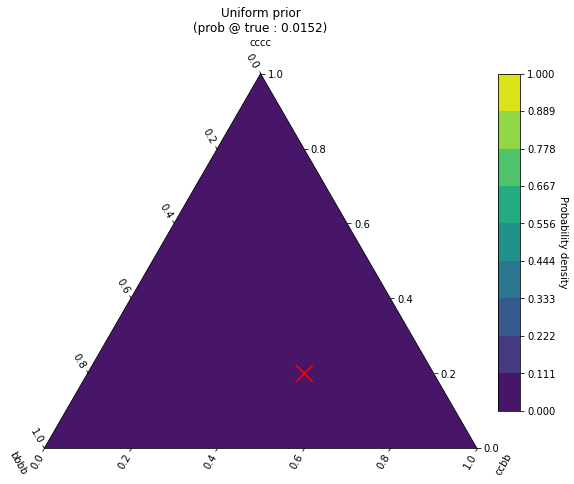

fraction mean: [0.1222625 0.4624375 0.4153   ] 
Absolute distance: 0.199


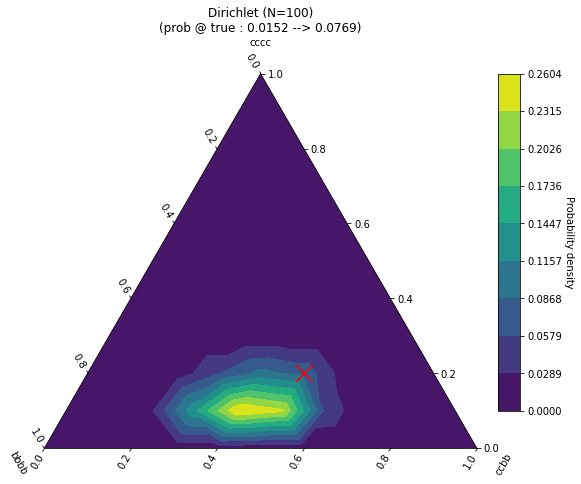

fraction mean: [0.1373875 0.40145   0.4611625] 
Absolute distance: 0.125


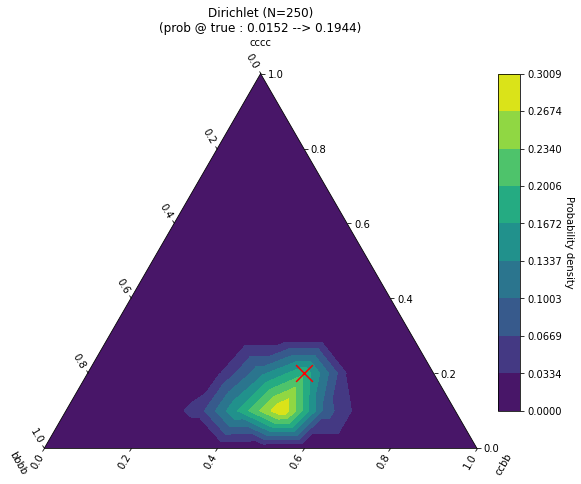

fraction mean: [0.14724 0.38816 0.4646 ] 
Absolute distance: 0.109


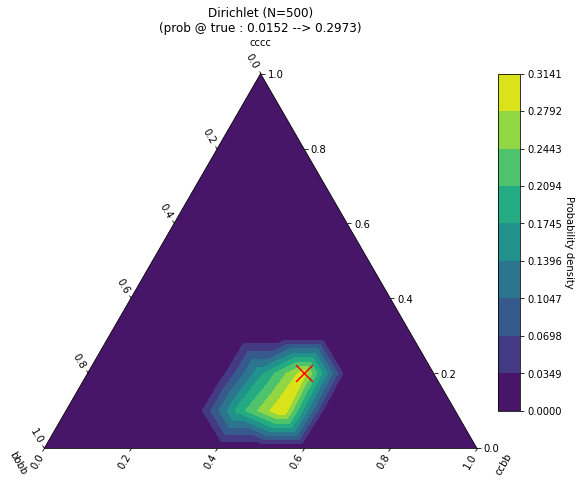

fraction mean: [0.1165    0.5844625 0.2990375] 
Absolute distance: 0.358


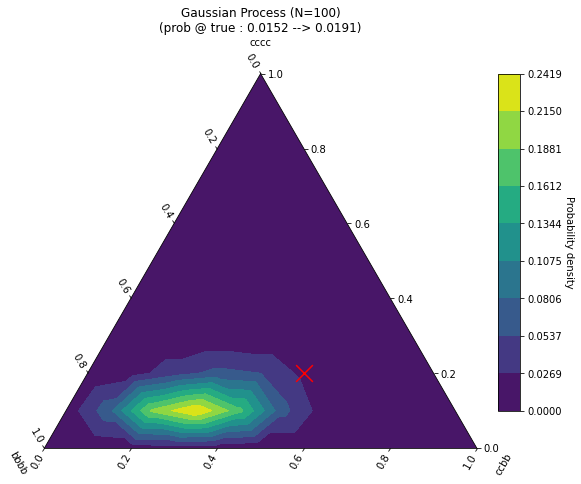

fraction mean: [0.13195  0.453575 0.414475] 
Absolute distance: 0.188


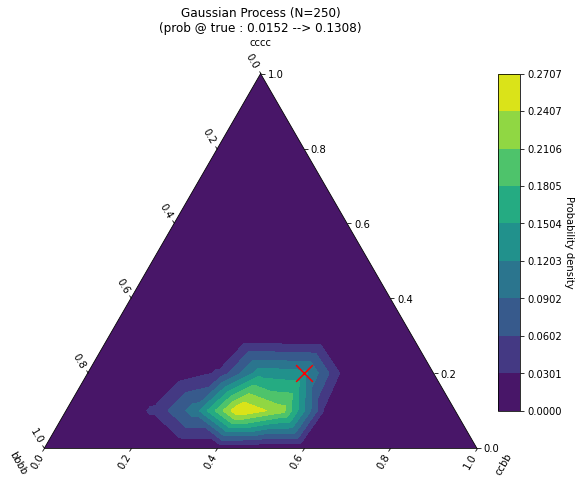

fraction mean: [0.163775 0.384075 0.45215 ] 
Absolute distance: 0.103


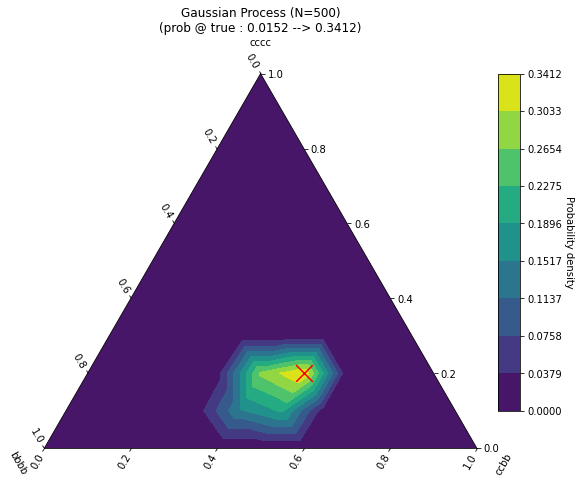

fraction mean: [0.28249167 0.36025    0.35725833] 
Absolute distance: 0.176


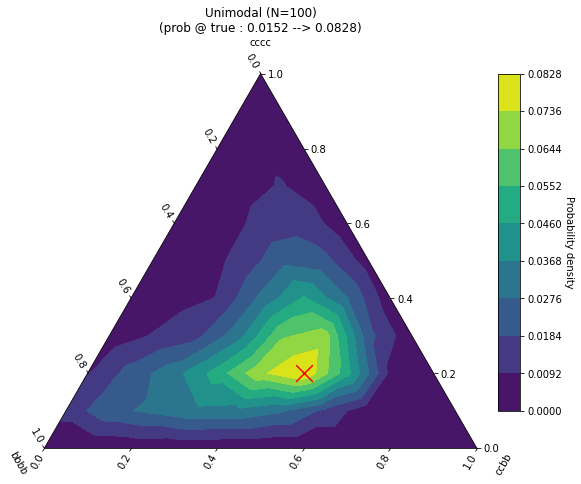

fraction mean: [0.25264167 0.25736667 0.48999167] 
Absolute distance: 0.068


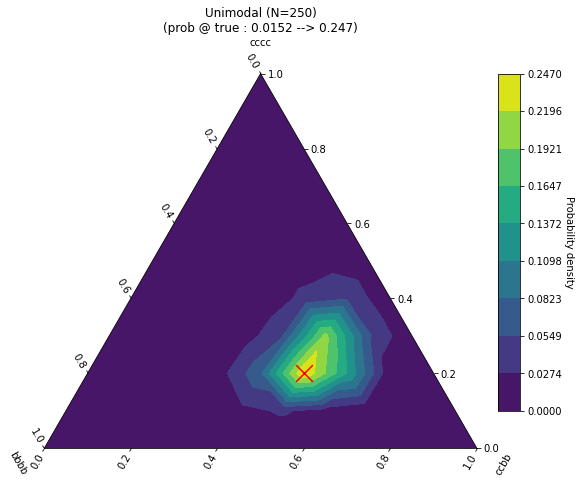

fraction mean: [0.25704375 0.23229375 0.5106625 ] 
Absolute distance: 0.089


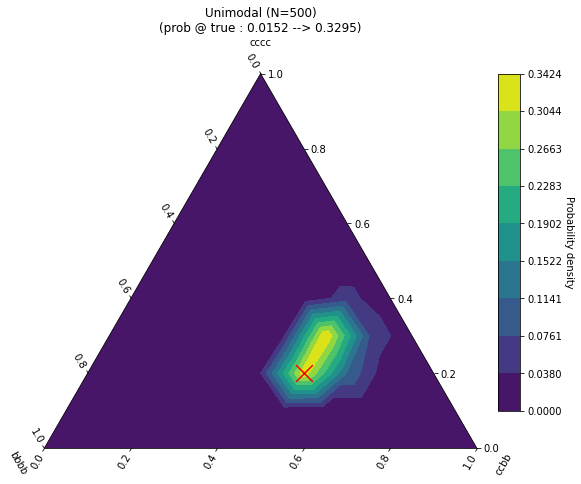

fraction mean: [0.270125 0.2182   0.511675] 
Absolute distance: 0.108


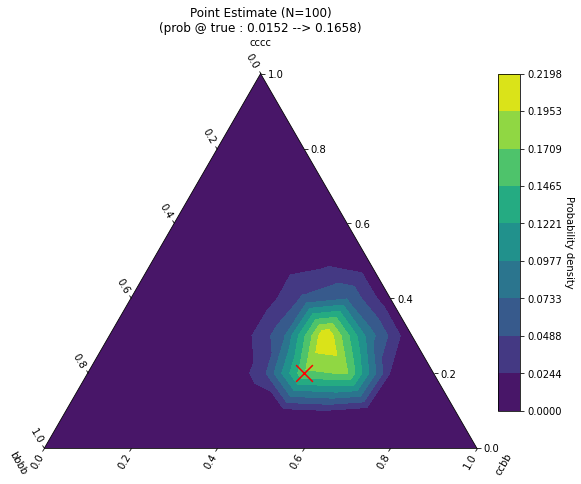

fraction mean: [0.24135  0.221825 0.536825] 
Absolute distance: 0.096


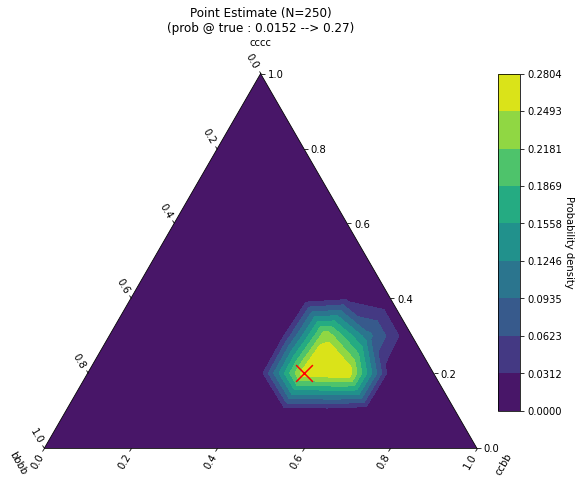

fraction mean: [0.25430833 0.22195833 0.52373333] 
Absolute distance: 0.098


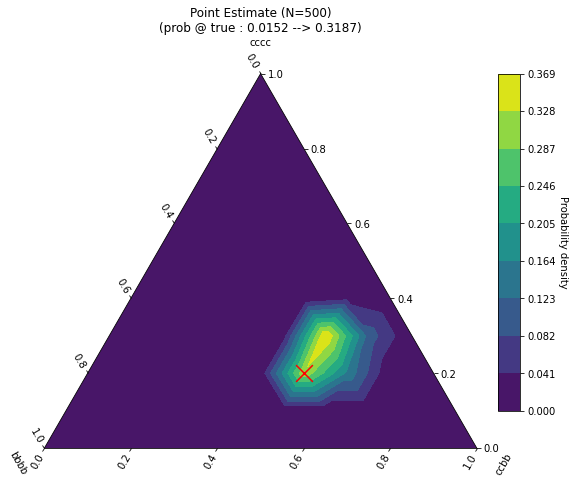

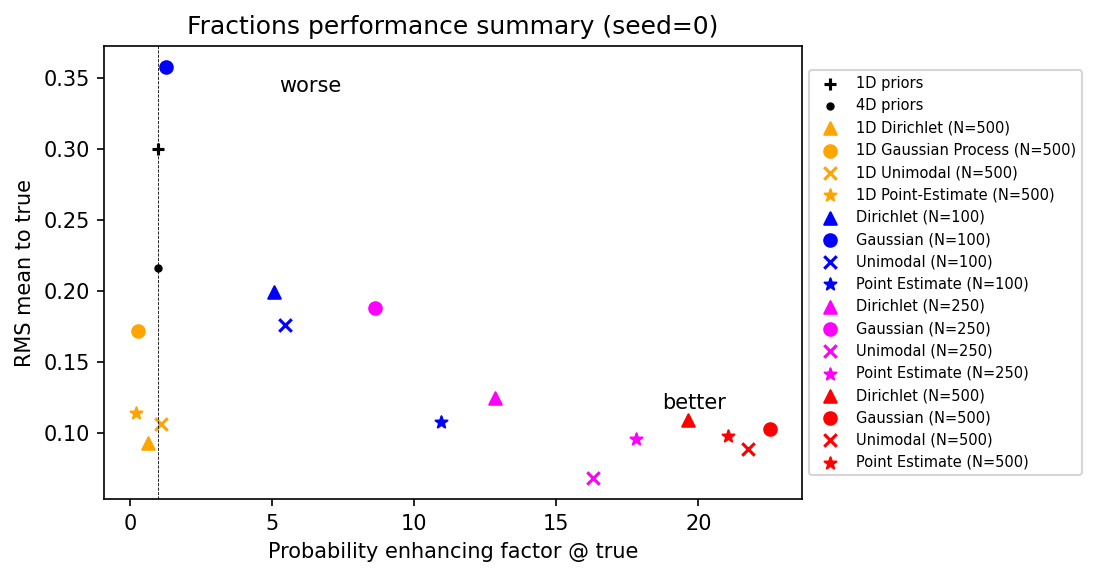

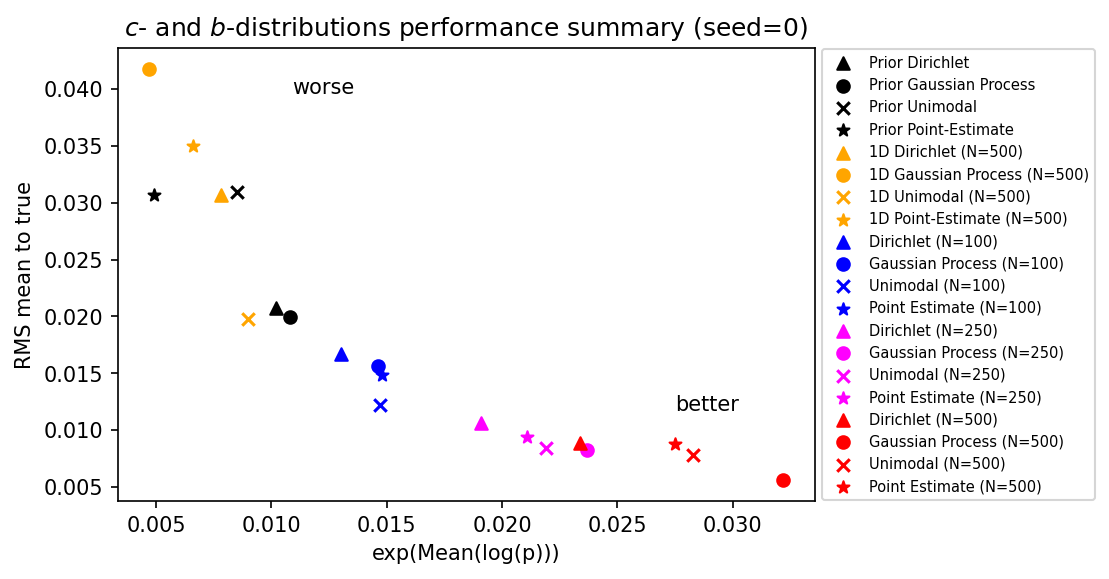

In [15]:
process_results(name = 'seed=0v3',
    key_1Ddr500 = '1D01-03-2024.17.03Dr',
    key_1Dgp500 = '1D29-02-2024.23.50hs',
    key_1Dum500 = '1D01-03-2024.17.16UM',
    key_1Dpe500 = '1D19-03-2024.00.26PE',
    key_dr100 = '15-01-2024.07.34Dr',
    key_dr250 = '07-12-2023.23.07Dr',
    key_dr500 = '03-12-2023.01.14Dr',
    key_gp100 = '15-01-2024.07.46hs',
    key_gp250 = '10-11-2023.22.25hs',
    key_gp500 = '20-11-2023.07.14hs',
    key_um100 = '15-01-2024.07.43UM',
    key_um250 = '07-12-2023.23.22UM',
    key_um500 = '07-12-2023.08.29UM',
    key_pe100 = '26-02-2024.11.29PE',
    key_pe250 = '08-12-2023.19.32PE',
    key_pe500 = '08-12-2023.20.00PE')

#### Seed = 10000

fraction mean: [0.33333333 0.33333333 0.33333333] 
Absolute distance: 0.216


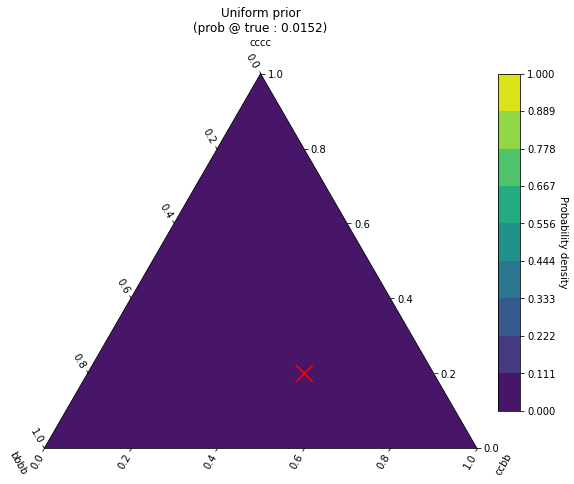

fraction mean: [0.14703125 0.3476125  0.50535625] 
Absolute distance: 0.071


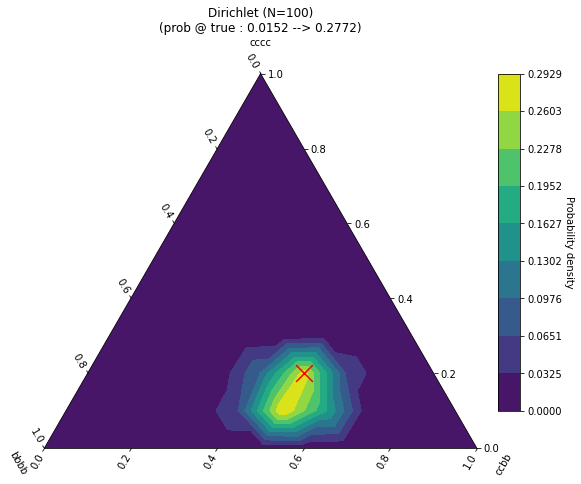

fraction mean: [0.15013333 0.3359     0.51396667] 
Absolute distance: 0.063


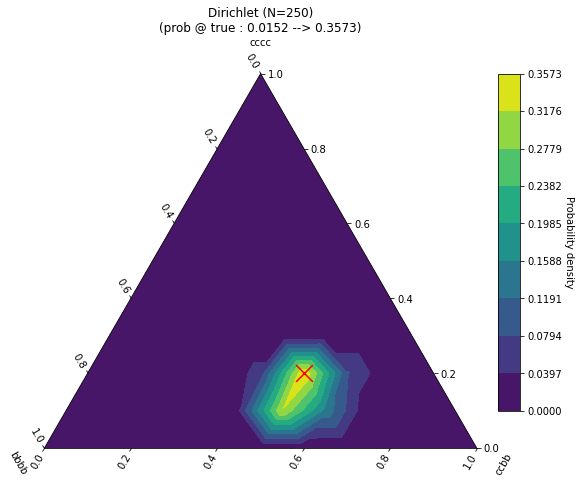

fraction mean: [0.188825 0.3174   0.493775] 
Absolute distance: 0.022


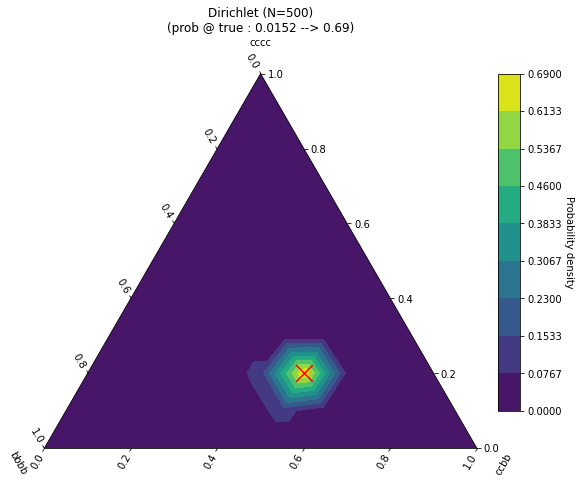

fraction mean: [0.155975 0.356225 0.4878  ] 
Absolute distance: 0.072


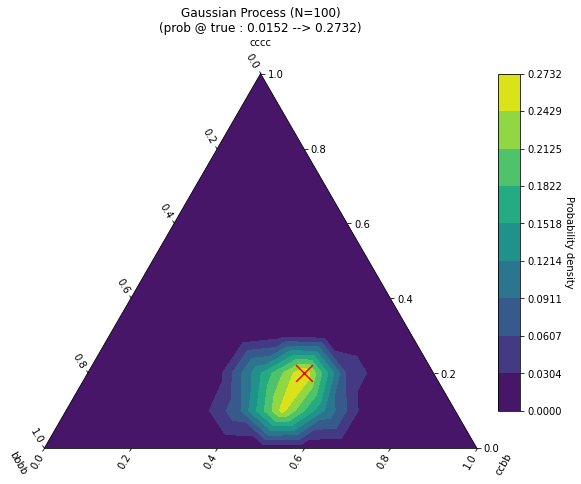

fraction mean: [0.166775 0.33985  0.493375] 
Absolute distance: 0.052


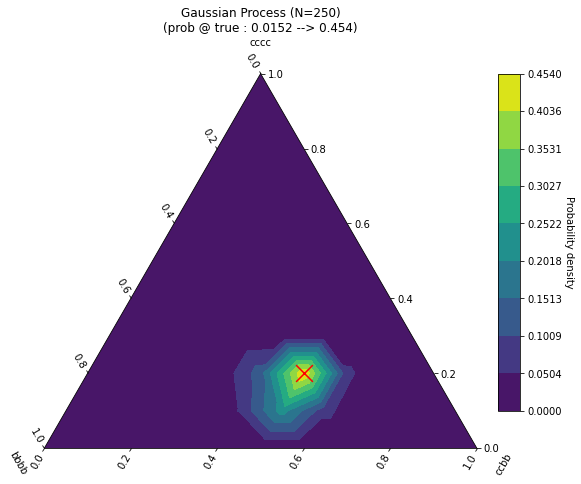

fraction mean: [0.194925 0.3403   0.464775] 
Absolute distance: 0.054


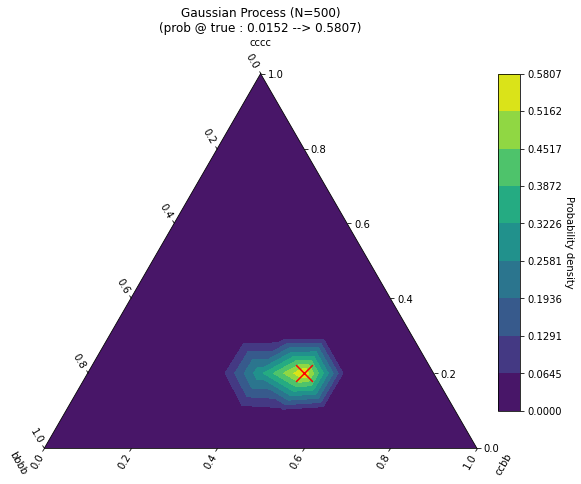

fraction mean: [0.29795 0.2623  0.43975] 
Absolute distance: 0.121


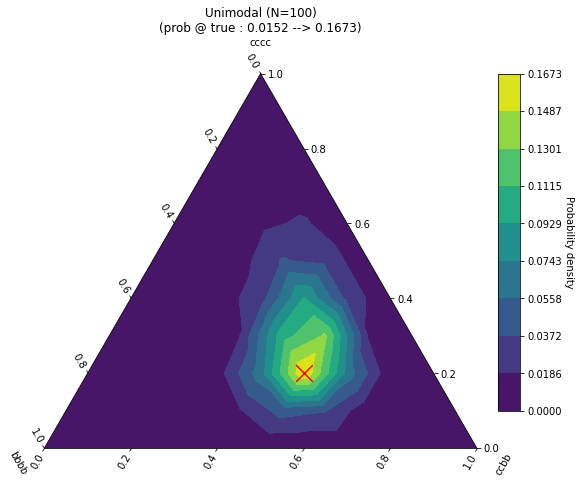

fraction mean: [0.244125 0.253025 0.50285 ] 
Absolute distance: 0.065


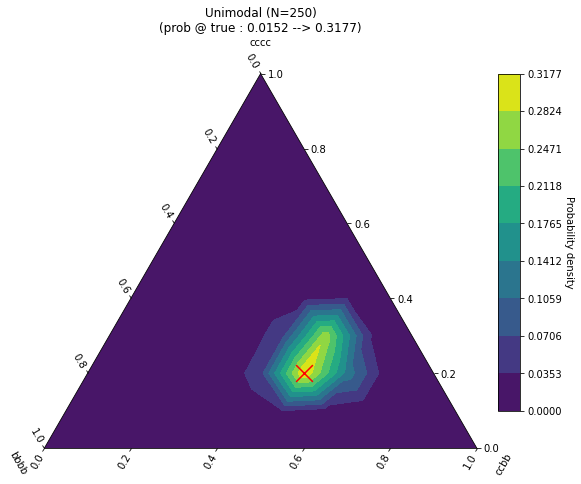

fraction mean: [0.29625 0.21035 0.4934 ] 
Absolute distance: 0.132


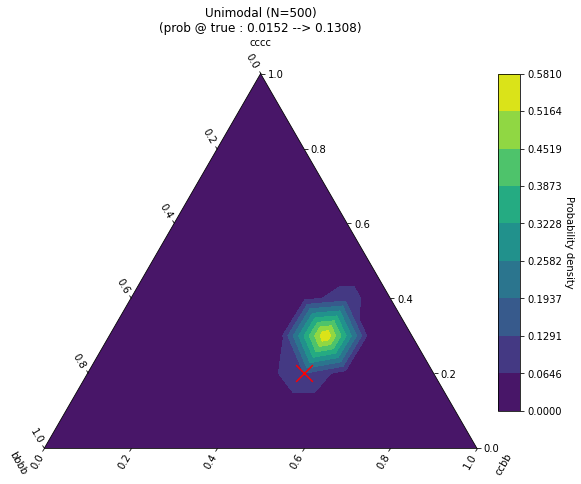

fraction mean: [0.336125 0.20865  0.455225] 
Absolute distance: 0.17


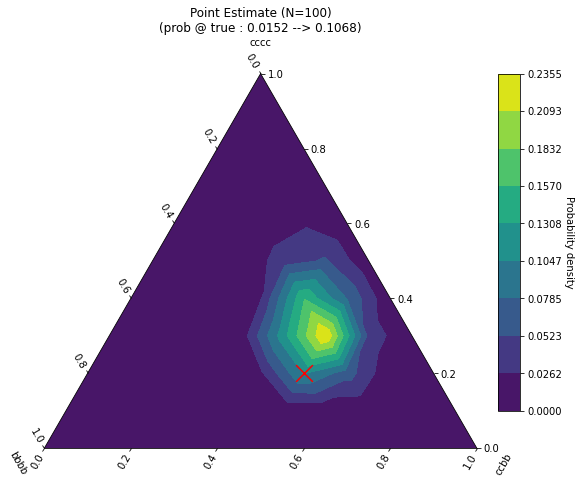

fraction mean: [0.290525 0.19535  0.514125] 
Absolute distance: 0.139


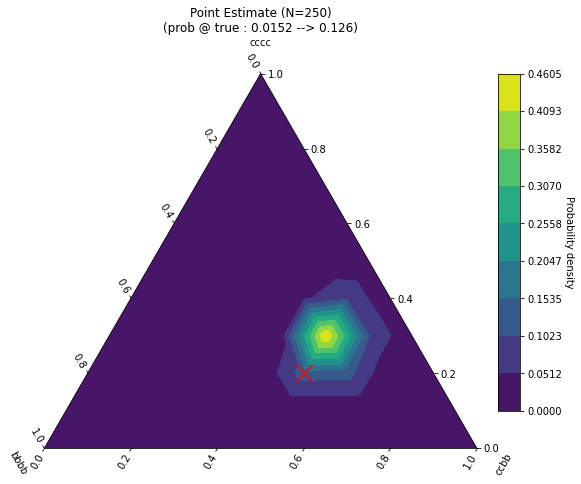

fraction mean: [0.3254 0.1747 0.4999] 
Absolute distance: 0.177


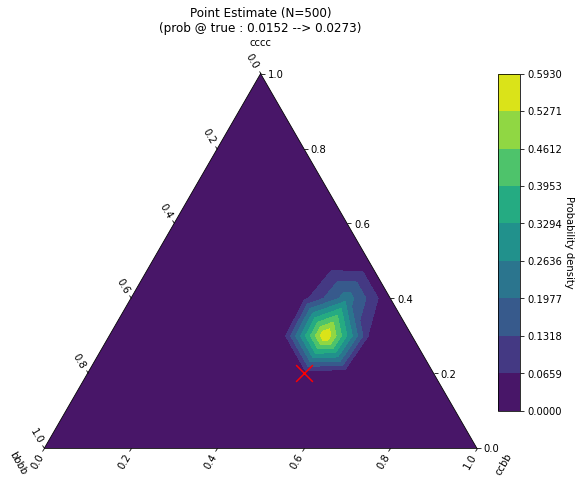

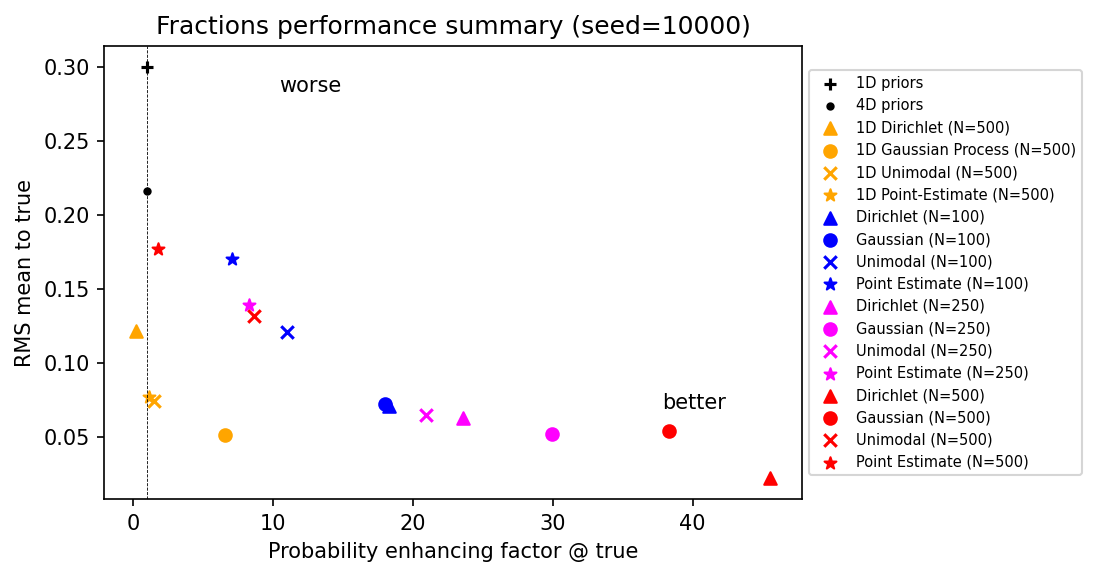

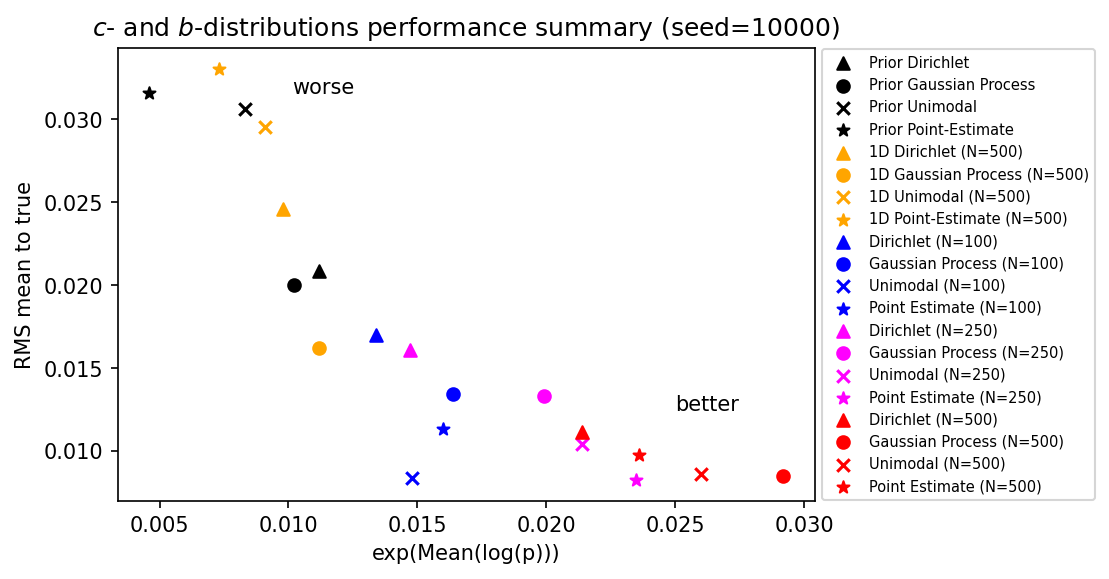

In [12]:
process_results(name = 'seed=10000v3',
    key_1Ddr500 = '1D01-03-2024.17.05Dr',
    key_1Dgp500 = '1D01-03-2024.07.28hs',
    key_1Dum500 = '1D01-03-2024.17.17UM',
    key_1Dpe500 = '1D21-03-2024.16.33PE',
    key_dr100 = '24-01-2024.16.06Dr',
    key_dr250 = '24-01-2024.16.34Dr',
    key_dr500 = '24-01-2024.16.52Dr',
    key_gp100 = '21-01-2024.21.23hs',
    key_gp250 = '22-01-2024.22.07hs',
    key_gp500 = '21-01-2024.21.18hs',
    key_um100 = '24-01-2024.16.12UM',
    key_um250 = '24-01-2024.16.41UM',
    key_um500 = '24-01-2024.19.07UM',
    key_pe100 = '29-02-2024.23.30PE',
    key_pe250 = '24-01-2024.19.33PE',
    key_pe500 = '24-01-2024.19.23PE')

#### Seed = 10

fraction mean: [0.33333333 0.33333333 0.33333333] 
Absolute distance: 0.216


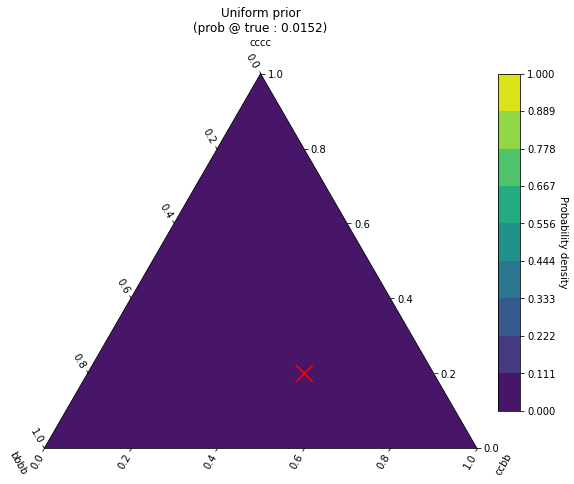

fraction mean: [0.162825  0.2977625 0.5394125] 
Absolute distance: 0.054


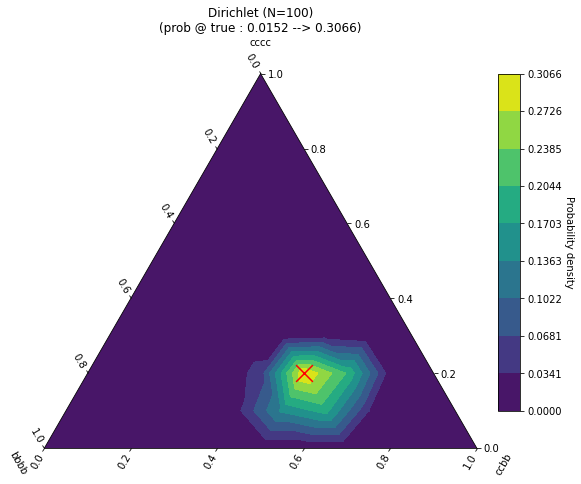

fraction mean: [0.149525 0.27375  0.576725] 
Absolute distance: 0.096


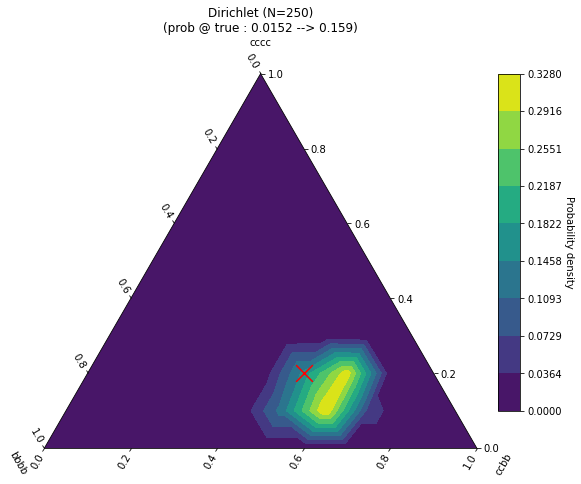

fraction mean: [0.1441 0.2869 0.569 ] 
Absolute distance: 0.09


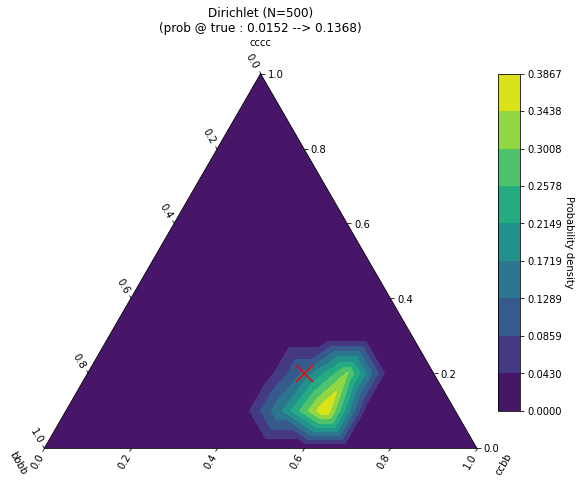

fraction mean: [0.11965 0.3894  0.49095] 
Absolute distance: 0.121


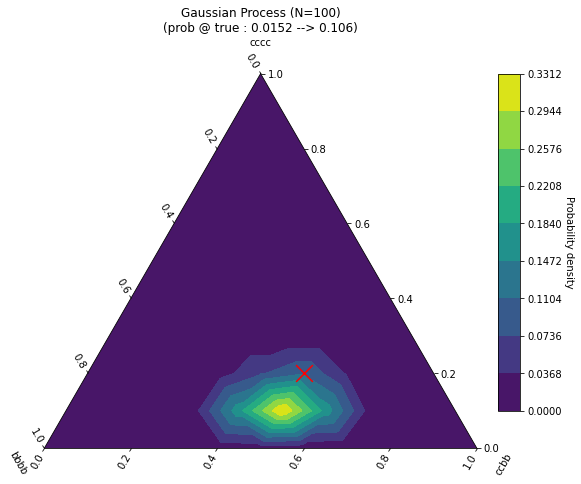

fraction mean: [0.15205  0.291025 0.556925] 
Absolute distance: 0.075


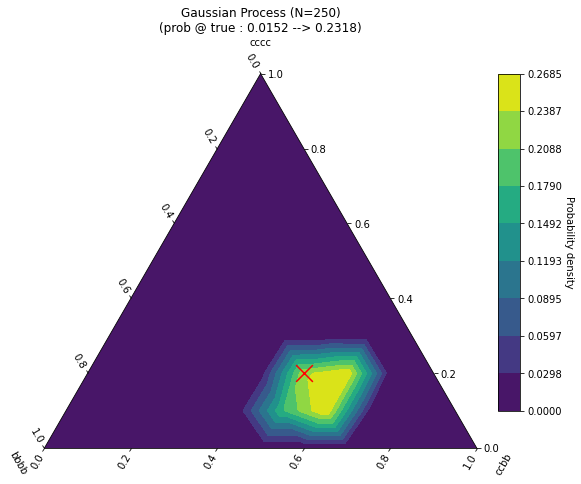

fraction mean: [0.157075 0.298725 0.5442  ] 
Absolute distance: 0.062


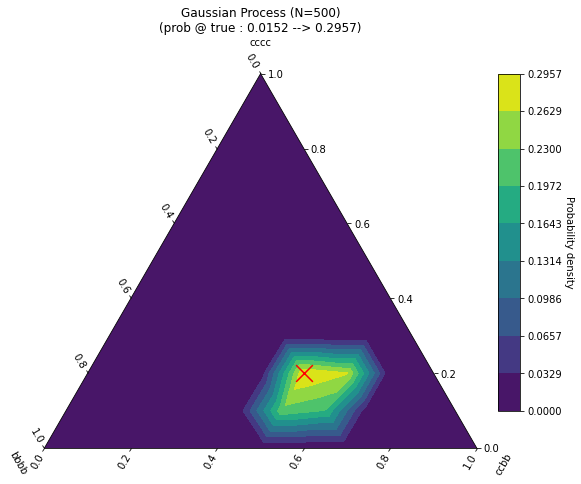

fraction mean: [0.21134167 0.373475   0.41518333] 
Absolute distance: 0.113


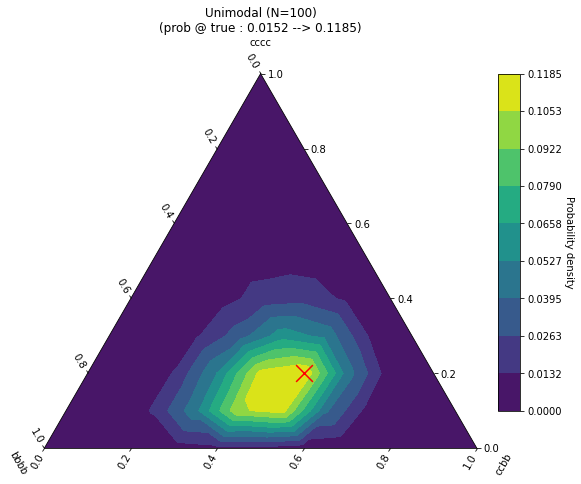

fraction mean: [0.22161 0.23439 0.544  ] 
Absolute distance: 0.082


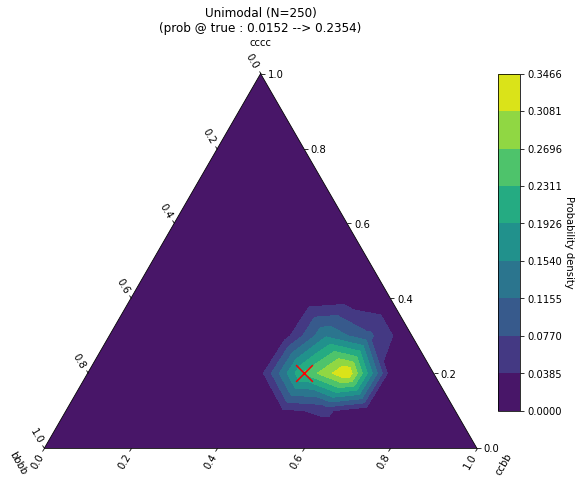

fraction mean: [0.2309   0.226175 0.542925] 
Absolute distance: 0.091


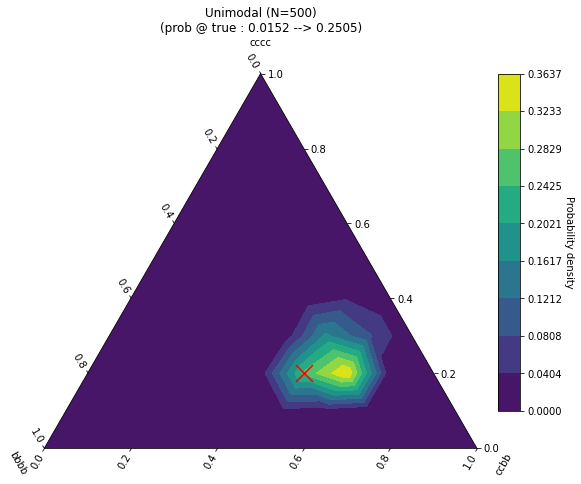

fraction mean: [0.25566667 0.19835    0.54598333] 
Absolute distance: 0.125


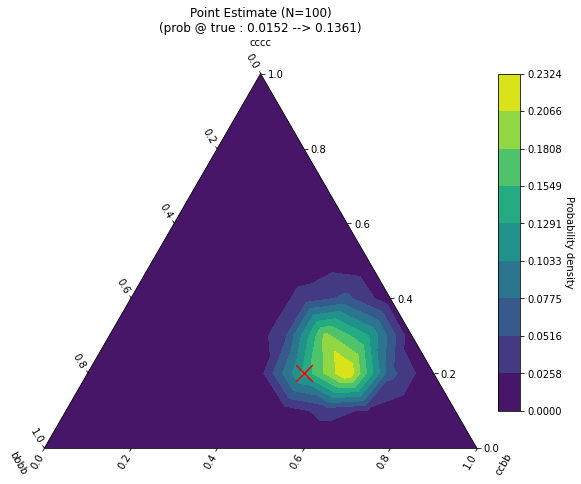

fraction mean: [0.233725 0.187375 0.5789  ] 
Absolute distance: 0.142


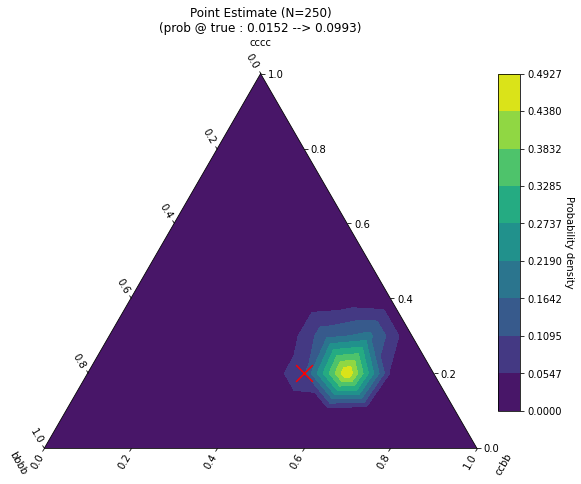

fraction mean: [0.222325 0.200775 0.5769  ] 
Absolute distance: 0.128


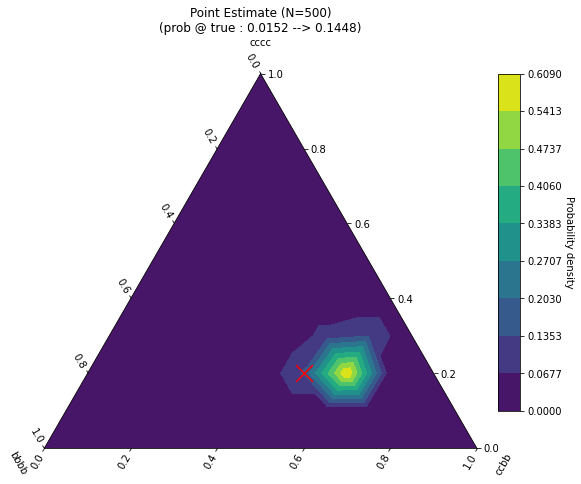

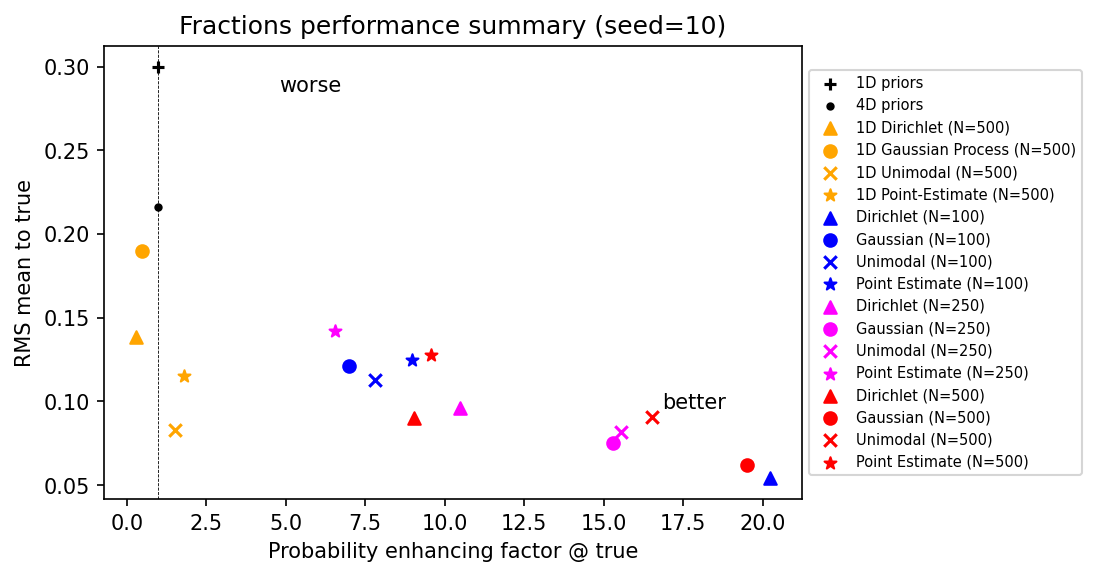

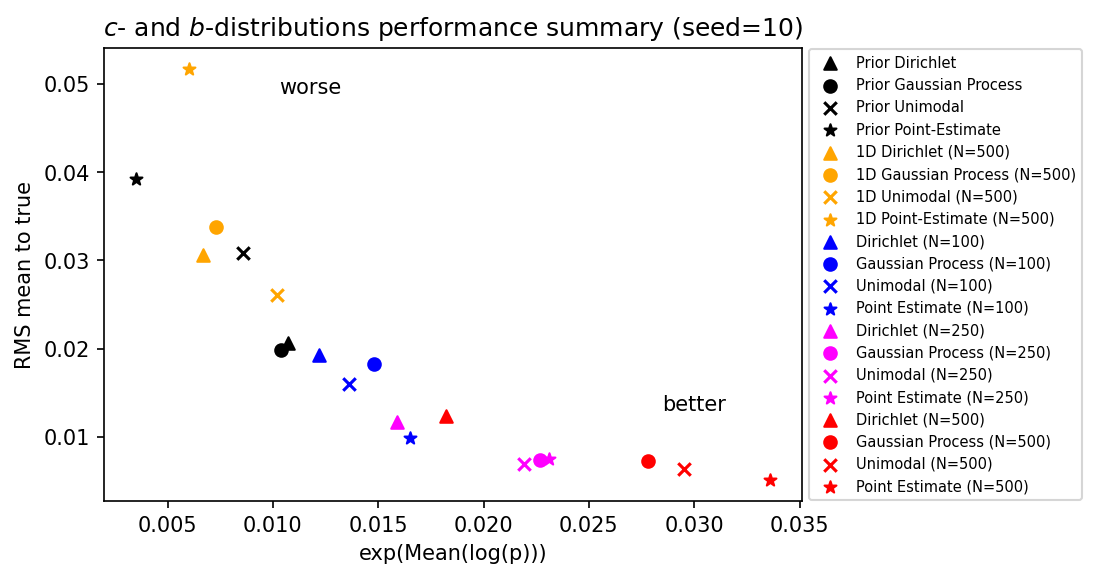

In [15]:
process_results(name = 'seed=10v3',
    key_1Ddr500 = '1D01-03-2024.17.02Dr',
    key_1Dgp500 = '1D29-02-2024.23.54hs',
    key_1Dum500 = '1D01-03-2024.17.09UM',
    key_1Dpe500 = '1D21-03-2024.17.04PE',
    key_dr100 = '07-12-2023.22.16Dr',
    key_dr250 = '28-02-2024.20.08Dr',
    key_dr500 = '28-02-2024.20.09Dr',
    key_gp100 = '20-11-2023.00.39hs',
    key_gp250 = '14-11-2023.16.35hs',
    key_gp500 = '19-11-2023.15.59hs',
    key_um100 = '07-12-2023.22.29UM',
    key_um250 = '28-02-2024.20.21um',
    key_um500 = '28-02-2024.20.10um',
    key_pe100 = '08-12-2023.20.08PE',
    key_pe250 = '29-02-2024.22.11PE',
    key_pe500 = '29-02-2024.21.54PE')

#### Seed = 30

fraction mean: [0.33333333 0.33333333 0.33333333] 
Absolute distance: 0.216


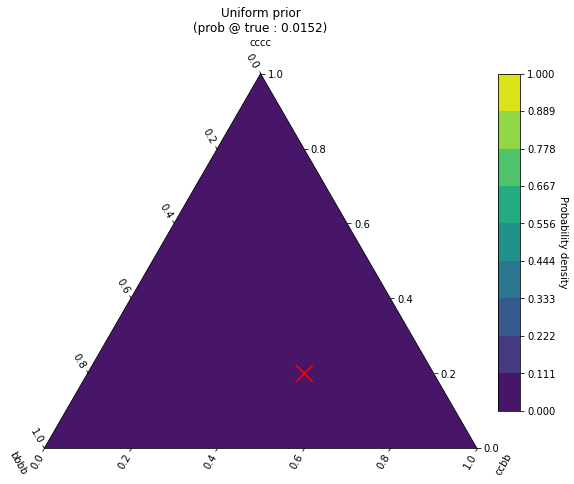

fraction mean: [0.1028125 0.2987875 0.5984   ] 
Absolute distance: 0.138


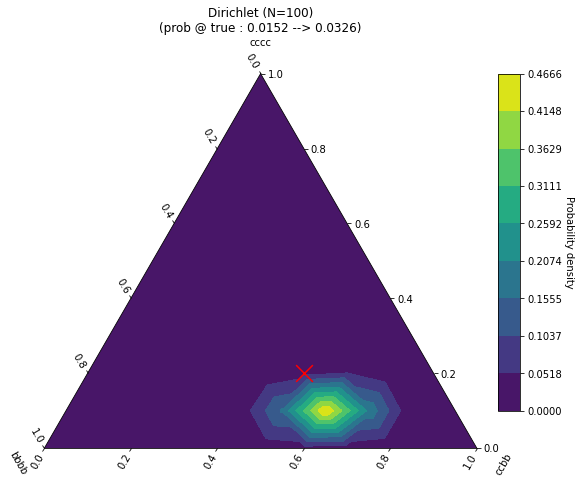

fraction mean: [0.1537875 0.2771    0.5691125] 
Absolute distance: 0.086


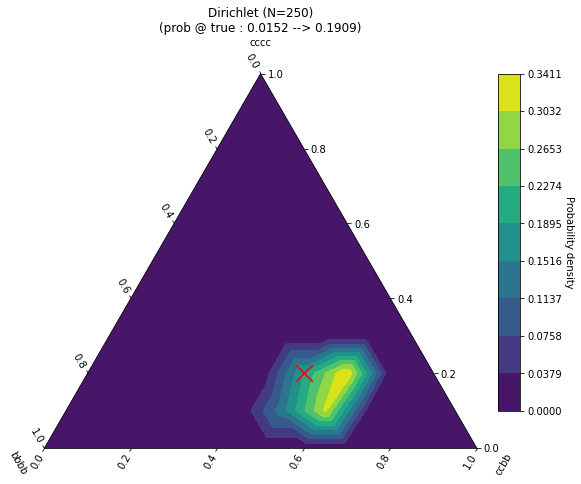

fraction mean: [0.1595375 0.4180375 0.422425 ] 
Absolute distance: 0.147


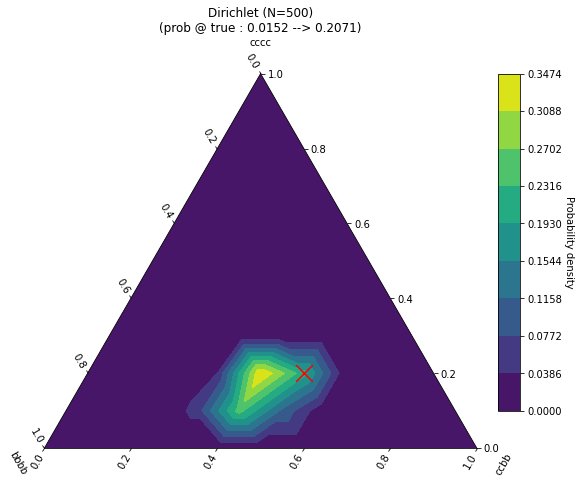

fraction mean: [0.10305 0.3426  0.55435] 
Absolute distance: 0.119


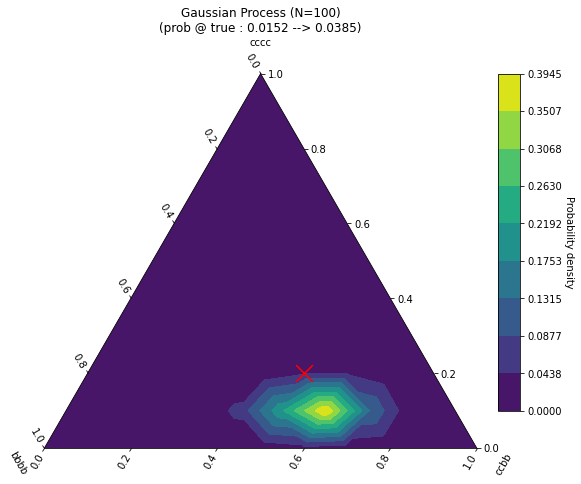

fraction mean: [0.164325 0.309975 0.5257  ] 
Absolute distance: 0.045


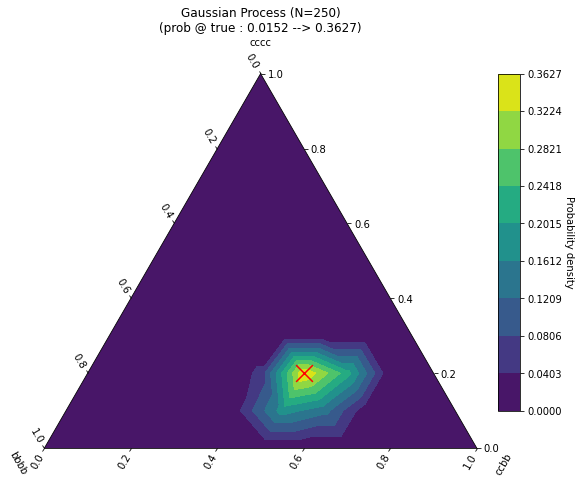

fraction mean: [0.1722   0.435875 0.391925] 
Absolute distance: 0.176


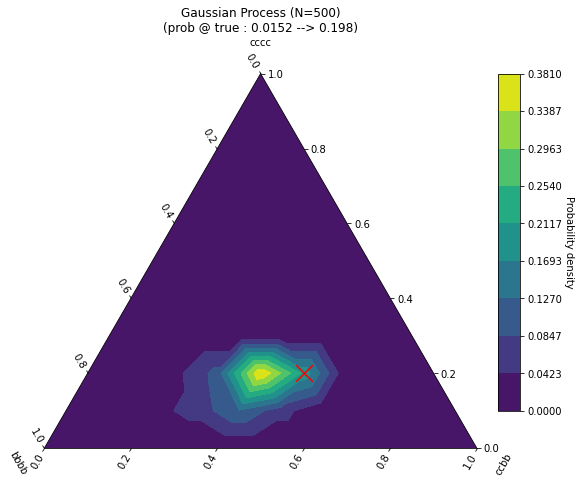

fraction mean: [0.15475    0.20701667 0.63823333] 
Absolute distance: 0.173


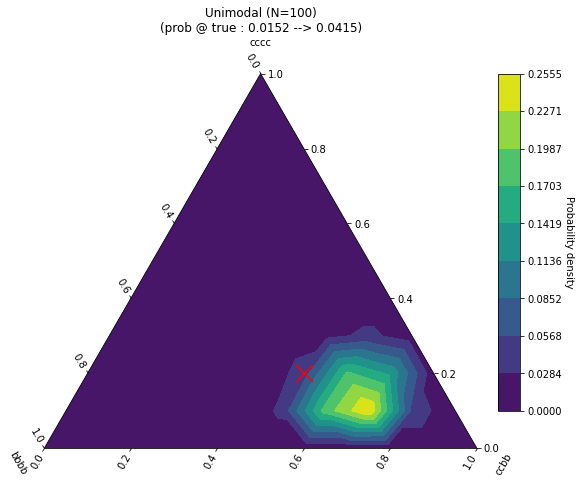

fraction mean: [0.22753333 0.21828333 0.55418333] 
Absolute distance: 0.102


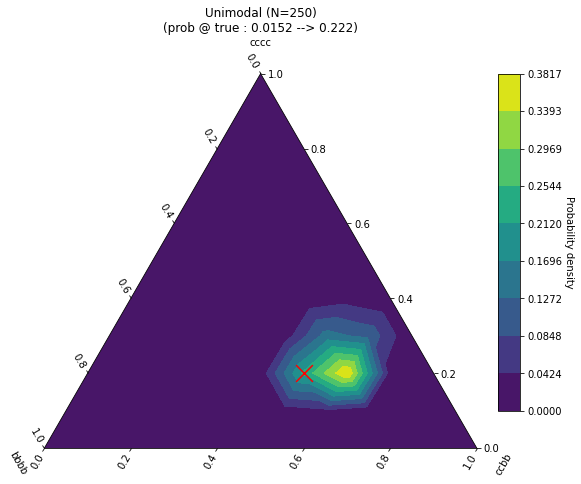

fraction mean: [0.28476667 0.25803333 0.4572    ] 
Absolute distance: 0.104


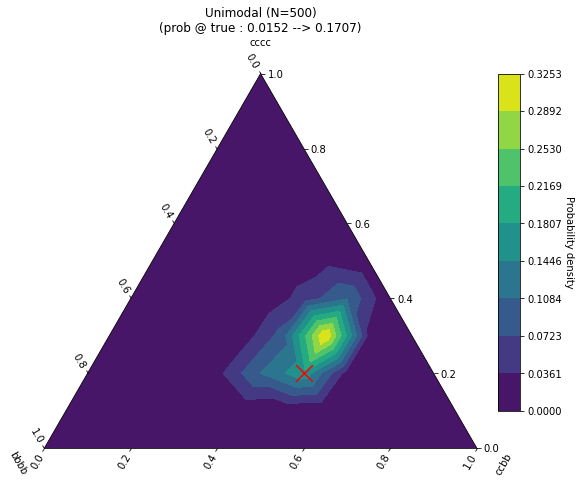

fraction mean: [0.1586 0.1767 0.6647] 
Absolute distance: 0.21


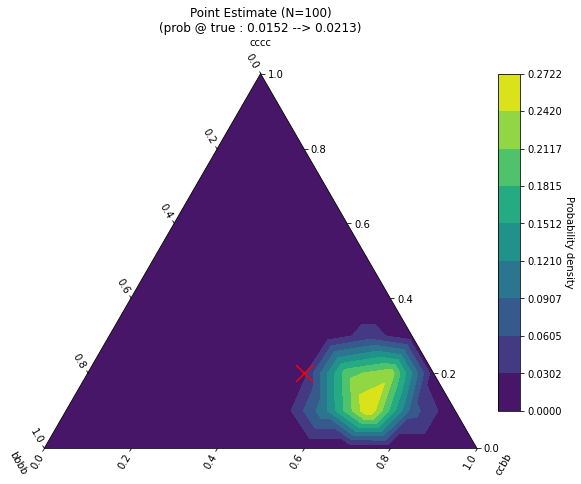

fraction mean: [0.22845 0.19245 0.5791 ] 
Absolute distance: 0.137


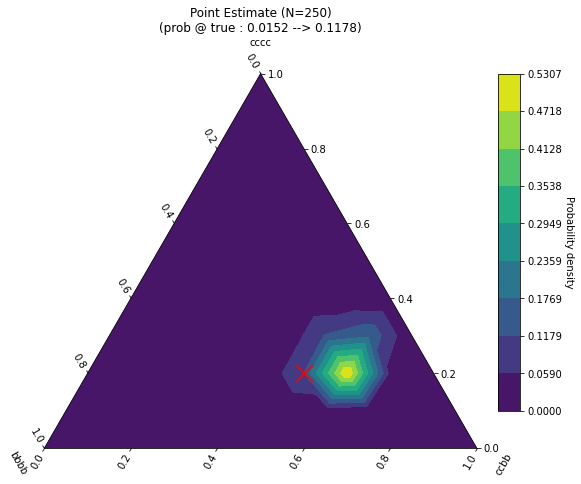

fraction mean: [0.29095 0.20275 0.5063 ] 
Absolute distance: 0.133


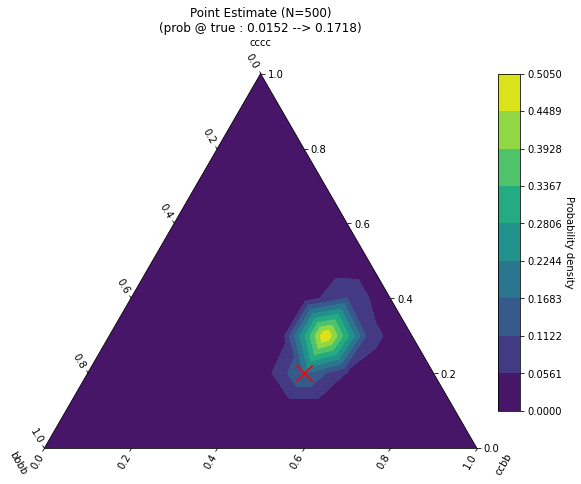

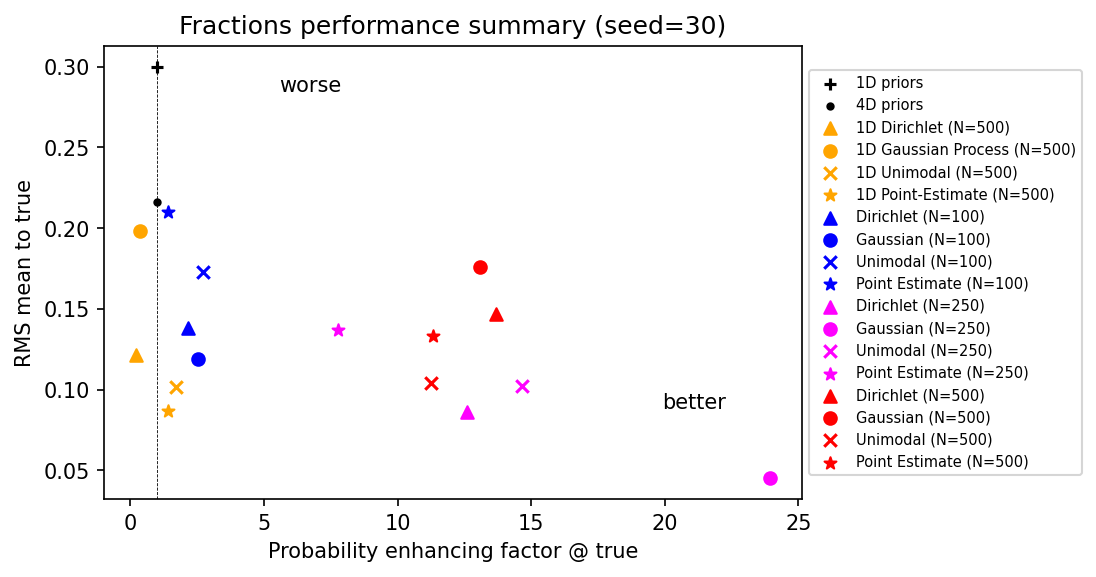

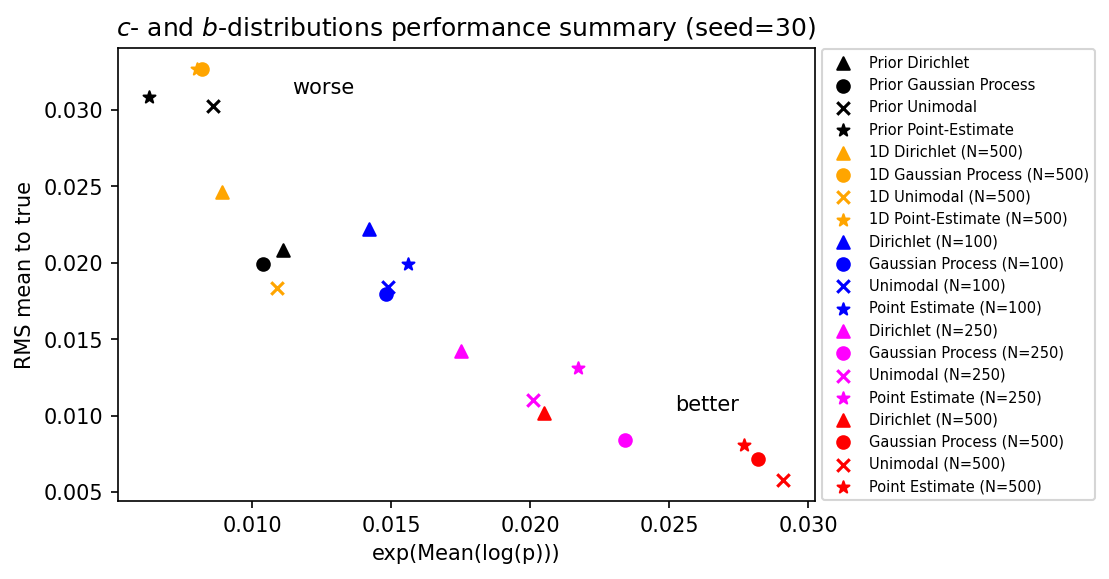

In [13]:
process_results(name = 'seed=30v3',
    key_1Ddr500 = '1D01-03-2024.17.05Dr',
    key_1Dgp500 = '1D01-03-2024.07.27hs',
    key_1Dum500 = '1D01-03-2024.17.12UM',
    key_1Dpe500 = '1D21-03-2024.17.00PE',
    key_dr100 = '28-02-2024.22.13Dr', 
    key_dr250 = '28-02-2024.22.48Dr',
    key_dr500 = '28-02-2024.22.18Dr', 
    key_gp100 = '28-02-2024.10.50hs', 
    key_gp250 = '27-02-2024.18.36hs', 
    key_gp500 = '24-02-2024.20.17hs', 
    key_um100 = '28-02-2024.22.15UM', 
    key_um250 = '28-02-2024.22.24UM', 
    key_um500 = '28-02-2024.22.47UM', 
    key_pe100 = '28-02-2024.22.52PE', 
    key_pe250 = '28-02-2024.22.54PE', 
    key_pe500 = '28-02-2024.23.12PE')